In [4]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from pydmd import HODMD
import matplotlib.gridspec as gs
import numpy.matlib as mb

import ipywidgets as widgets


import optuna
from optuna import Trial

from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice


from prettytable import PrettyTable

import warnings
warnings.filterwarnings("ignore")

In [5]:
#Read Data
df = pd.read_csv("../Dataset/IndiaStateWise/Cleaned_each_day.csv",header=1)
df = df.fillna(method="ffill")
df = df.drop("0",axis=1)
daily_cases = df.ewm(span=60,axis=0).mean().T
daily_cases.drop(["UT","DD","UN"],axis=0,inplace=True)
cumulative_cases = daily_cases.cumsum(axis=1)
states = daily_cases.T.columns
daily_cases.shape

(35, 1028)

In [6]:
sample = daily_cases.iloc[0,:]
def moments(arr):
    mean = np.mean(arr)
    variance = np.var(arr)
    skewness = np.mean((arr - mean)**3 / variance**(3/2))
    kurtosis = np.mean((arr - mean)**4 / variance**2) - 3

    return [mean,variance,skewness,kurtosis]

def stripize(X,window_size=100):
    strips = []
    momnts = []
    timestamps = []
    t = np.arange(len(X))
    for i in range(0,X.shape[0]-window_size,window_size):
        
        strip = X[i:i+window_size].ravel()
        timestamps.append(t[i:i+window_size].ravel())
        strips.append(strip)
        momnts.append(moments(strip))

    strips=np.array(strips)
    momnts = np.array(momnts)

    return strips,momnts,timestamps

strips,moments,timestamps = stripize(sample.values,window_size=30)

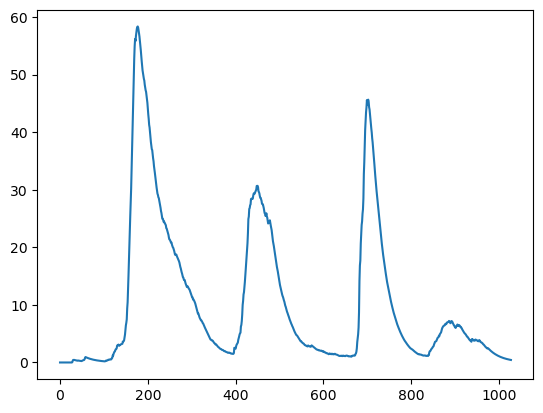

In [41]:
plt.plot(sample)

16

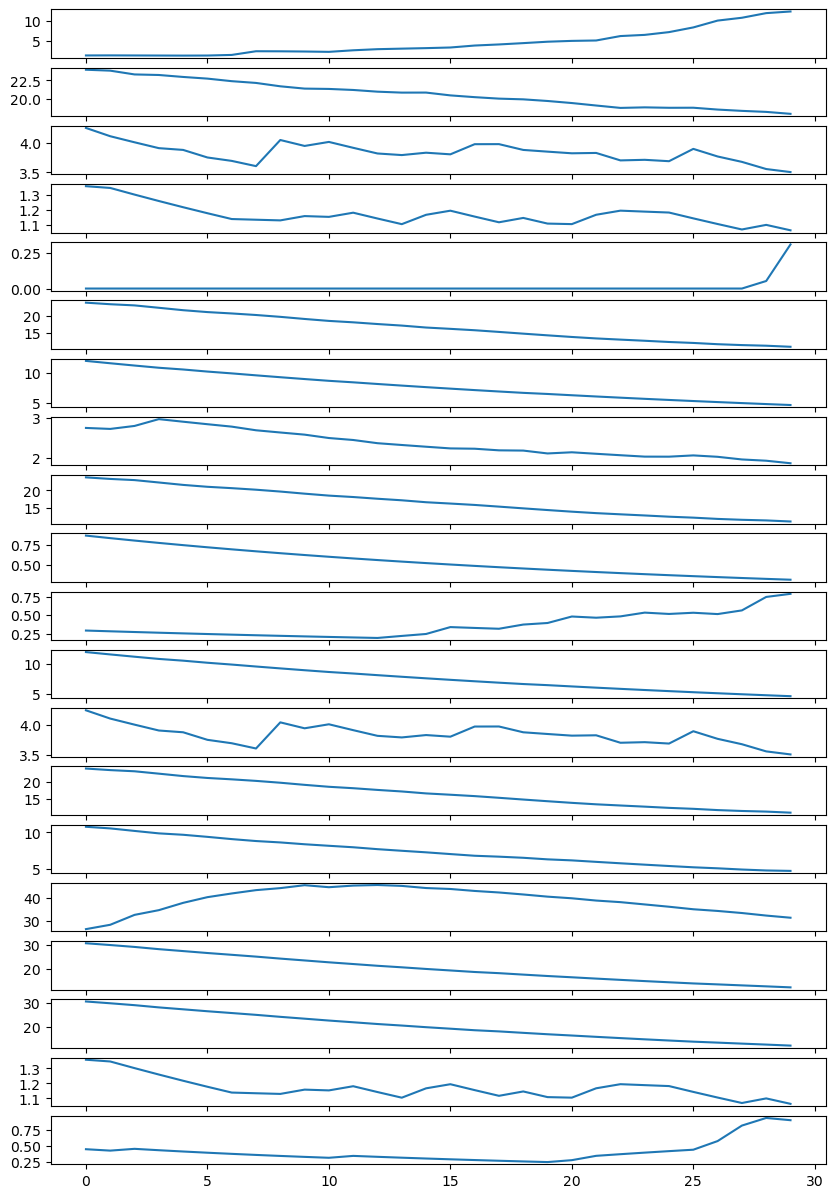

In [49]:
fig = plt.figure(figsize=(10,15))
N=20
gs = fig.add_gridspec(nrows=N,ncols=1)

for i in range(N):
    ax = fig.add_subplot(gs[i,0])
    ax.plot(strips[np.random.randint(0,len(strips)-1)])

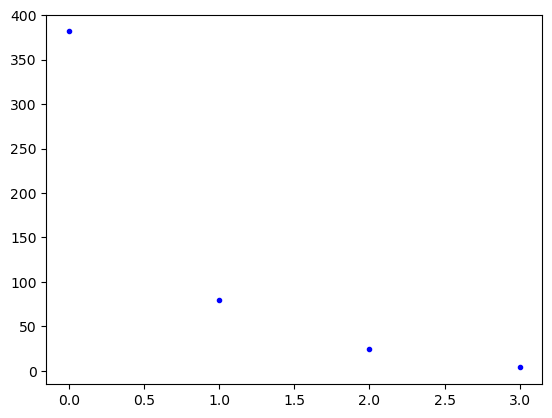

In [50]:
plt.plot(S,'.b')

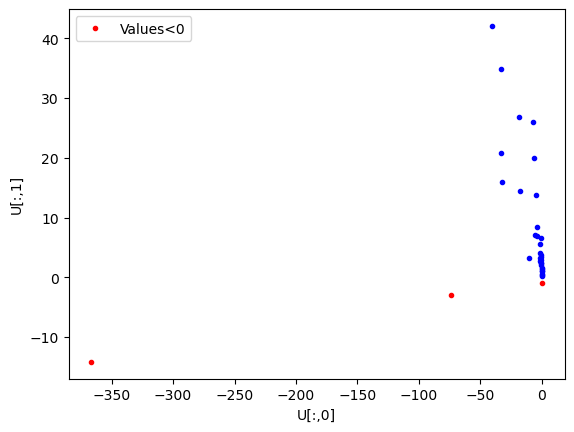

In [52]:
U,S,V = np.linalg.svd(moments)


X_ = U[:,:2]@np.diag(S[:2])
x = X_[:,0]
y = X_[:,1]
th=0
plt.plot(x[y<th],y[y<th],'.r',label=f"Values<{th}")
plt.plot(x[y>=th],y[y>=th],'.b')
plt.xlabel("U[:,0]")
plt.ylabel("U[:,1]")
plt.legend()




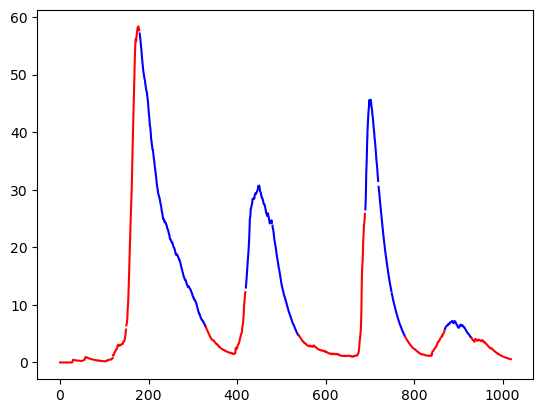

In [55]:
def plot_clr(strips, mask):
    for i in range(len(strips)):
        
        if mask[i]==True:
            plt.plot(timestamps[i],strips[i],'r')
        if mask[i]==False:
            plt.plot(timestamps[i],strips[i],'b')

plot_clr(strips,X_[:,1]<5)

In [7]:


class Experiment():
    
    def __init__(self, X,
                 train_params = {"start_day":0, "train_days":40, "pred_days":5},
                 HODMD_params = { "svd_rank":0, "tlsq_rank":0, "exact":False, "opt":False,
                 "rescale_mode":None, "forward_backward":False, "d":35,
                 "sorted_eigs":False, "reconstruction_method":"first",
                 "svd_rank_extra":0},
                row_mask=None):
        self.start_day = train_params["start_day"]
        self.train_days = train_params["train_days"]
        self.pred_days = train_params["pred_days"]
        self.X = X
        self.DMD = HODMD(**HODMD_params)
        
        self.row_mask = row_mask
        self.train_data ,self.ground_truth = Experiment.train_test_split(self.X,self.train_days,self.pred_days,self.start_day,self.row_mask)
        self.metrics = {}

    @staticmethod
    def train_test_split(df,train_days,pred_days,start_day,row_mask=None):
        if row_mask==None:
            train = df.loc[:,start_day:start_day+train_days-1]
            test = df.loc[:, start_day+train_days: start_day+train_days+pred_days-1]
        else:
            try:
                train = df.loc[row_mask,start_day:start_day+train_days-1]
                test = df.loc[row_mask, start_day+train_days: start_day+train_days+pred_days-1]
            except:
                raise Exception("mask should be compatible with the indices of rows")
    
        return train,test

    def fit(self):

        snapshot = self.train_data.to_numpy()
        self.DMD = self.DMD.fit(snapshot)
        #print(self.DMD.eigs.shape)
        #self.DMD.original_time['t0'] = self.DMD.dmd_time['t0'] = self.start_day
        self.DMD.original_time['tend'] = self.DMD.dmd_time['tend'] = (self.train_days-1)
        self.reconstructed_data = self.DMD.reconstructed_data.real
        
    def pred(self):
        #self.DMD.dmd_time['t0'] = self.start_day
      
        self.DMD.dmd_time['tend'] = ( self.train_days + self.pred_days - 1)
        
        self.pred_data =  self.DMD.reconstructed_data.real[:, self.train_days:(  self.train_days + self.pred_days)]
        #self.pred_data =  self.DMD.reconstructed_data.real
        
     
       # self.MAPE();
        return self.pred_data

    def MAPE(self):
        gt = self.ground_truth.to_numpy() 
        self.metrics["MAPE"] = np.abs((gt-self.pred_data)/(gt+0.00000001)).mean(axis=1)   
        return self.metrics["MAPE"]

    @staticmethod
    def MAPE_full(ground_truth,pred_data):
        gt =  ground_truth.to_numpy() 
        return np.abs((gt- pred_data)/(gt+0.00000001)).mean(axis=1)   

    def plot_pred(self,row_num=1,ax=None):
        #plt.plot(np.arange(self.start_day+self.train_days,(self.start_day + self.train_days + self.pred_days)),self.pred_data[row_num,:])

        #plt.plot(np.arange(self.start_day,self.start_day+self.train_days ),self.reconstructed_data[row_num,:])


        gt_time_steps = np.arange(self.start_day+self.train_days ,self.start_day+self.train_days +self.pred_days )
        train_time_steps = np.arange(self.start_day,self.start_day+self.train_days  )

        #plt.plot(gt_time_steps,self.ground_truth.iloc[row_num,:],'g')
    
        #plt.plot(train_time_steps, self.train_data.iloc[row_num,:],'r')
       # plt.plot(train_time_steps, self.reconstructed_data[row_num,:],'b')

        plt.plot(gt_time_steps , self.pred_data[row_num,:])
      
        #plt.legend([ "Predicted" , "Reconstructed", "Ground Truth", "Train Data"])
        
       # plt.legend(["GT","Train","Pred"])


        
    
 
        
        
        
        
        

In [8]:
def sliding_pred(X,train_days=60,pred_days=30,d=20):
    

    start_day=0

    train_params = {"start_day":start_day, "train_days":train_days, "pred_days":pred_days}
    HODMD_params = { "svd_rank":X.shape[0], "tlsq_rank":0, "exact":False, "opt":True,
                    "rescale_mode":None, "forward_backward":False, "d":d,
                    "sorted_eigs":False, "reconstruction_method":"first",
                    "svd_rank_extra":X.shape[0]}
    exps = []
    preds = []
    exp = Experiment(X,train_params=train_params,HODMD_params=HODMD_params);
    exp.fit();
    preds = exp.pred()
    pred_timesteps = np.arange(train_params["start_day"]+train_params["train_days"],train_params["start_day"]+train_params["train_days"]+ train_params["pred_days"])
    lambdas = mb.repmat(exp.DMD.eigs.reshape(-1,1),1,train_params["pred_days"] )
    for epoch_start_day in range(train_params["start_day"], X.shape[1]-(train_params["pred_days"]+train_params["train_days"]), train_params["pred_days"] ):  
        train_params_tilde = {"start_day":epoch_start_day, "train_days":train_days, "pred_days":pred_days}
        pred_timesteps = np.concatenate( (pred_timesteps, np.arange(epoch_start_day+train_params["train_days"],epoch_start_day+train_params["train_days"]+ train_params["pred_days"])))
        exp = Experiment(X,train_params=train_params_tilde,HODMD_params=HODMD_params);
        exp.fit();
        preds = np.concatenate((preds, exp.pred()), axis=1);
        exps.append(exp)
        lambdas = np.concatenate((lambdas,   mb.repmat(exp.DMD.eigs.reshape(-1,1),1,train_params_tilde["pred_days"] )    ), axis=1 )

    return pred_timesteps,preds,exps,lambdas
 
  
   


In [34]:


def daily_objective(trial:Trial,lam=0.5,return_info=False):
    train_days = trial.suggest_int("train_days",20,150)
    pred_days = trial.suggest_int("pred_days",15,60)
    d = trial.suggest_int("d",3,train_days-2)
    t,y,exps,lambdas = sliding_pred(daily_cases,train_days=train_days,pred_days=pred_days,d=d)
    score = ((1-lam)* Experiment.MAPE_full(daily_cases.iloc[:, t],y).sum()) + lam*(train_days/pred_days)

    if return_info:
        return score,t,y,exps, lambdas
    else:
        return score

study = optuna.create_study()
study.optimize(daily_objective, n_trials=250,n_jobs=-1)


[I 2023-03-30 14:26:23,182] A new study created in memory with name: no-name-fa2d5a5b-93bc-4047-987e-91dd9e1de6ec
[I 2023-03-30 14:26:25,780] Trial 0 finished with value: 6.76256795798693 and parameters: {'train_days': 27, 'pred_days': 37, 'd': 17}. Best is trial 0 with value: 6.76256795798693.
[I 2023-03-30 14:26:28,396] Trial 5 finished with value: 32.46456842979452 and parameters: {'train_days': 83, 'pred_days': 48, 'd': 25}. Best is trial 0 with value: 6.76256795798693.
[I 2023-03-30 14:26:28,492] Trial 6 finished with value: 23.59347744892315 and parameters: {'train_days': 42, 'pred_days': 47, 'd': 35}. Best is trial 0 with value: 6.76256795798693.
[I 2023-03-30 14:26:29,274] Trial 11 finished with value: 32.06148813816739 and parameters: {'train_days': 44, 'pred_days': 44, 'd': 34}. Best is trial 0 with value: 6.76256795798693.
[I 2023-03-30 14:26:30,210] Trial 8 finished with value: 11.145385245562675 and parameters: {'train_days': 73, 'pred_days': 58, 'd': 56}. Best is trial 0 

KeyboardInterrupt: 

In [267]:
study.best_params

{'train_days': 66, 'pred_days': 18, 'd': 55}

In [268]:
plot_optimization_history(study)




In [269]:
plot_parallel_coordinate(study)

In [270]:
plot_contour(study)

In [98]:
plot_slice(study)

In [271]:
plot_param_importances(study)

In [101]:
plot_edf(study)

In [9]:
t,y,exps,lambdas = sliding_pred(daily_cases,**{'train_days': 66, 'pred_days': 18, 'd': 55})


In [15]:
from sklearn.metrics import mean_squared_error

TypeError: mean_squared_error() got an unexpected keyword argument 'axis'

In [10]:
import numpy as np


def r_square(actual_values,predicted_values):
    # Calculate the mean actual and predicted values row-wise
    mean_actual = np.mean(actual_values, axis=1)
    mean_predicted = np.mean(predicted_values, axis=1)

    # Calculate the sum of squared differences between actual and predicted values row-wise
    ss_tot = np.sum(np.square(actual_values - mean_actual[:, np.newaxis]), axis=1)
    ss_res = np.sum(np.square(predicted_values - actual_values), axis=1)

    # Calculate R-squared row-wise
    rsquared = 1 - (ss_res / ss_tot)

    return rsquared

def mse_rmse(actual_values,predicted_values):
    # Calculate the squared errors row-wise
    squared_errors = np.square(actual_values - predicted_values)
    rowwise_squared_errors = np.sum(squared_errors, axis=1)
    # Calculate the RMSE row-wise
    rowwise_mse = (rowwise_squared_errors / actual_values.shape[1])
    rowwise_rmse = np.sqrt(rowwise_mse)
    return rowwise_mse,rowwise_rmse

def mae_mape(actual_values,predicted_values):
    # Calculate the absolute differences between actual and predicted values row-wise
    abs_diff = np.abs(predicted_values - actual_values)
    # Calculate MAE row-wise
    mae = np.mean(abs_diff, axis=1)
    # Calculate MAPE row-wise
    mape = np.mean(abs_diff / actual_values, axis=1) * 100

    return mae,mape



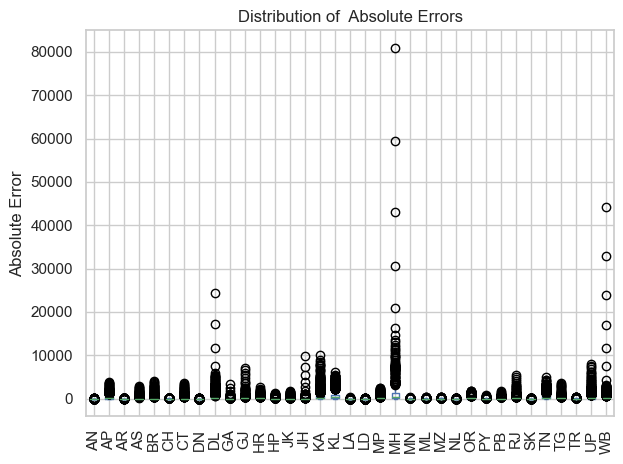

In [23]:
mse,rmse = mse_rmse(daily_cases.iloc[:,t],y)
mae,mape = mae_mape(daily_cases.iloc[:,t],y)
r2 = r_square(daily_cases.iloc[:,t],y)
scores =  pd.DataFrame({"r2": r2, "mae": mae,"mape":mape ,"mse":mse,"rmse":rmse,})

<Axes: ylabel='mape'>

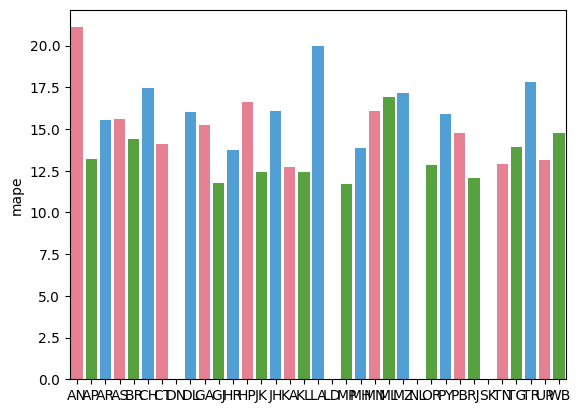

In [29]:
sns.barplot(x=df.index, y='mape', data=df, palette=colors)


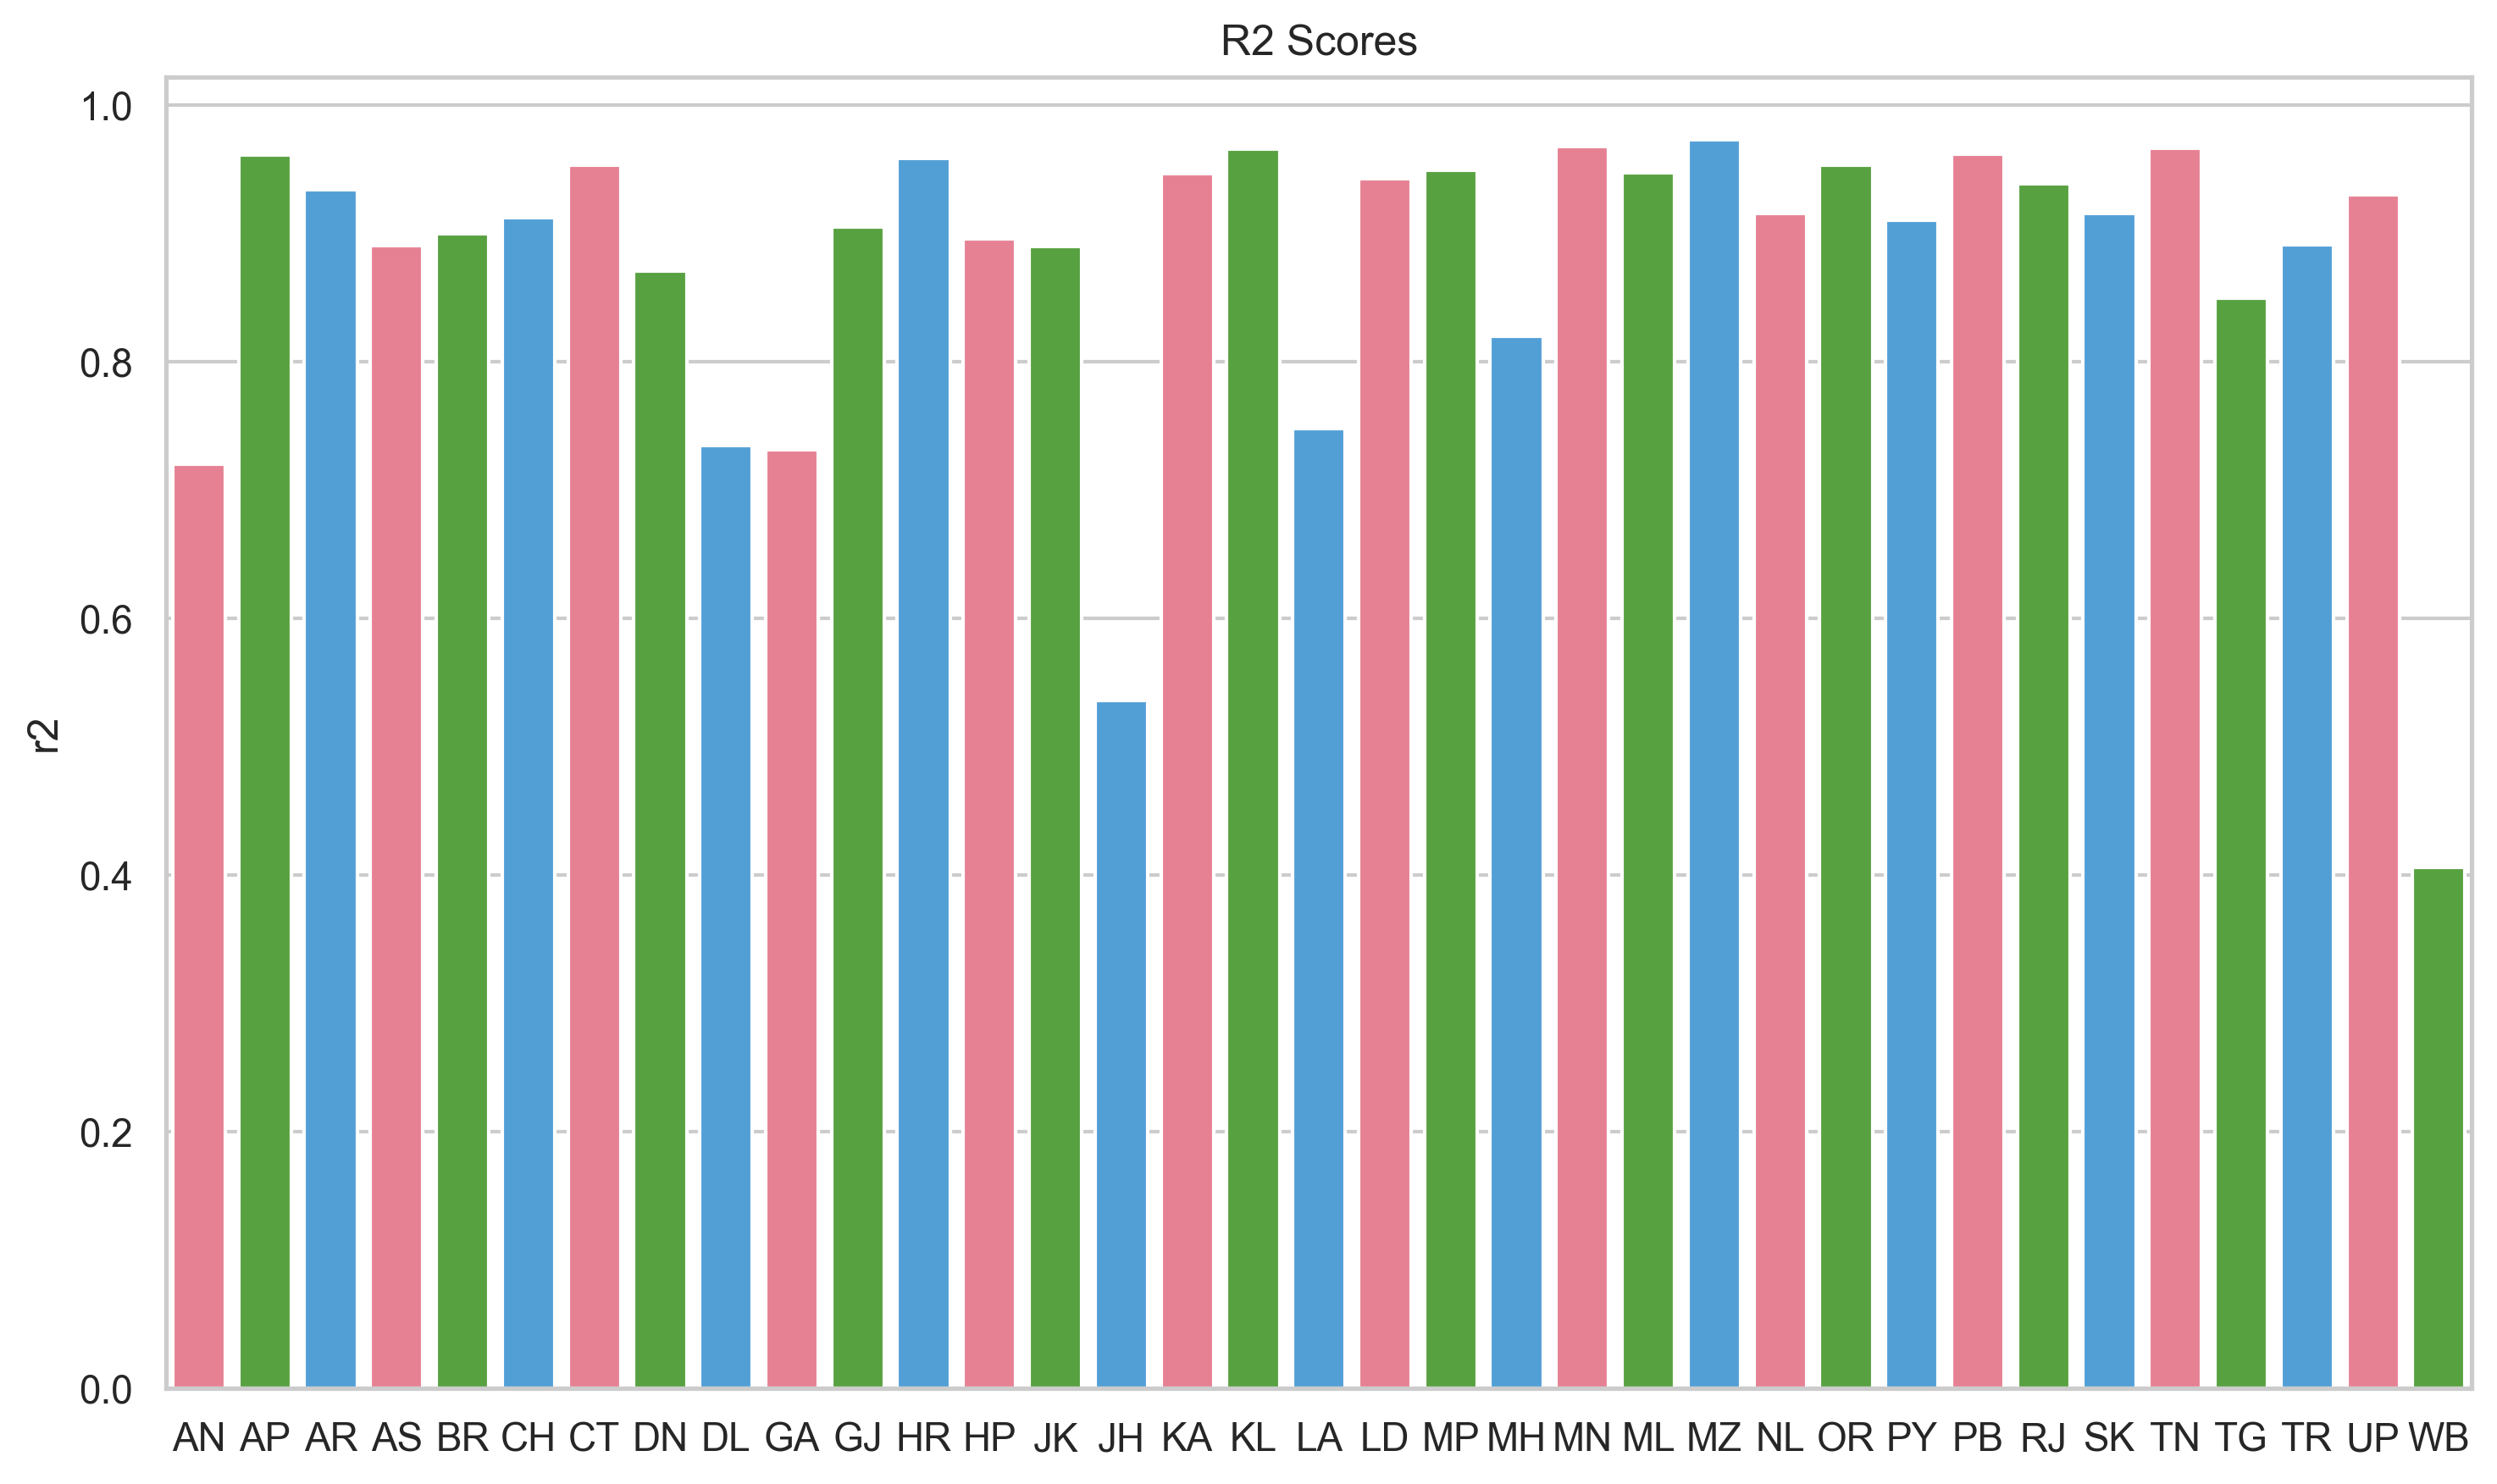

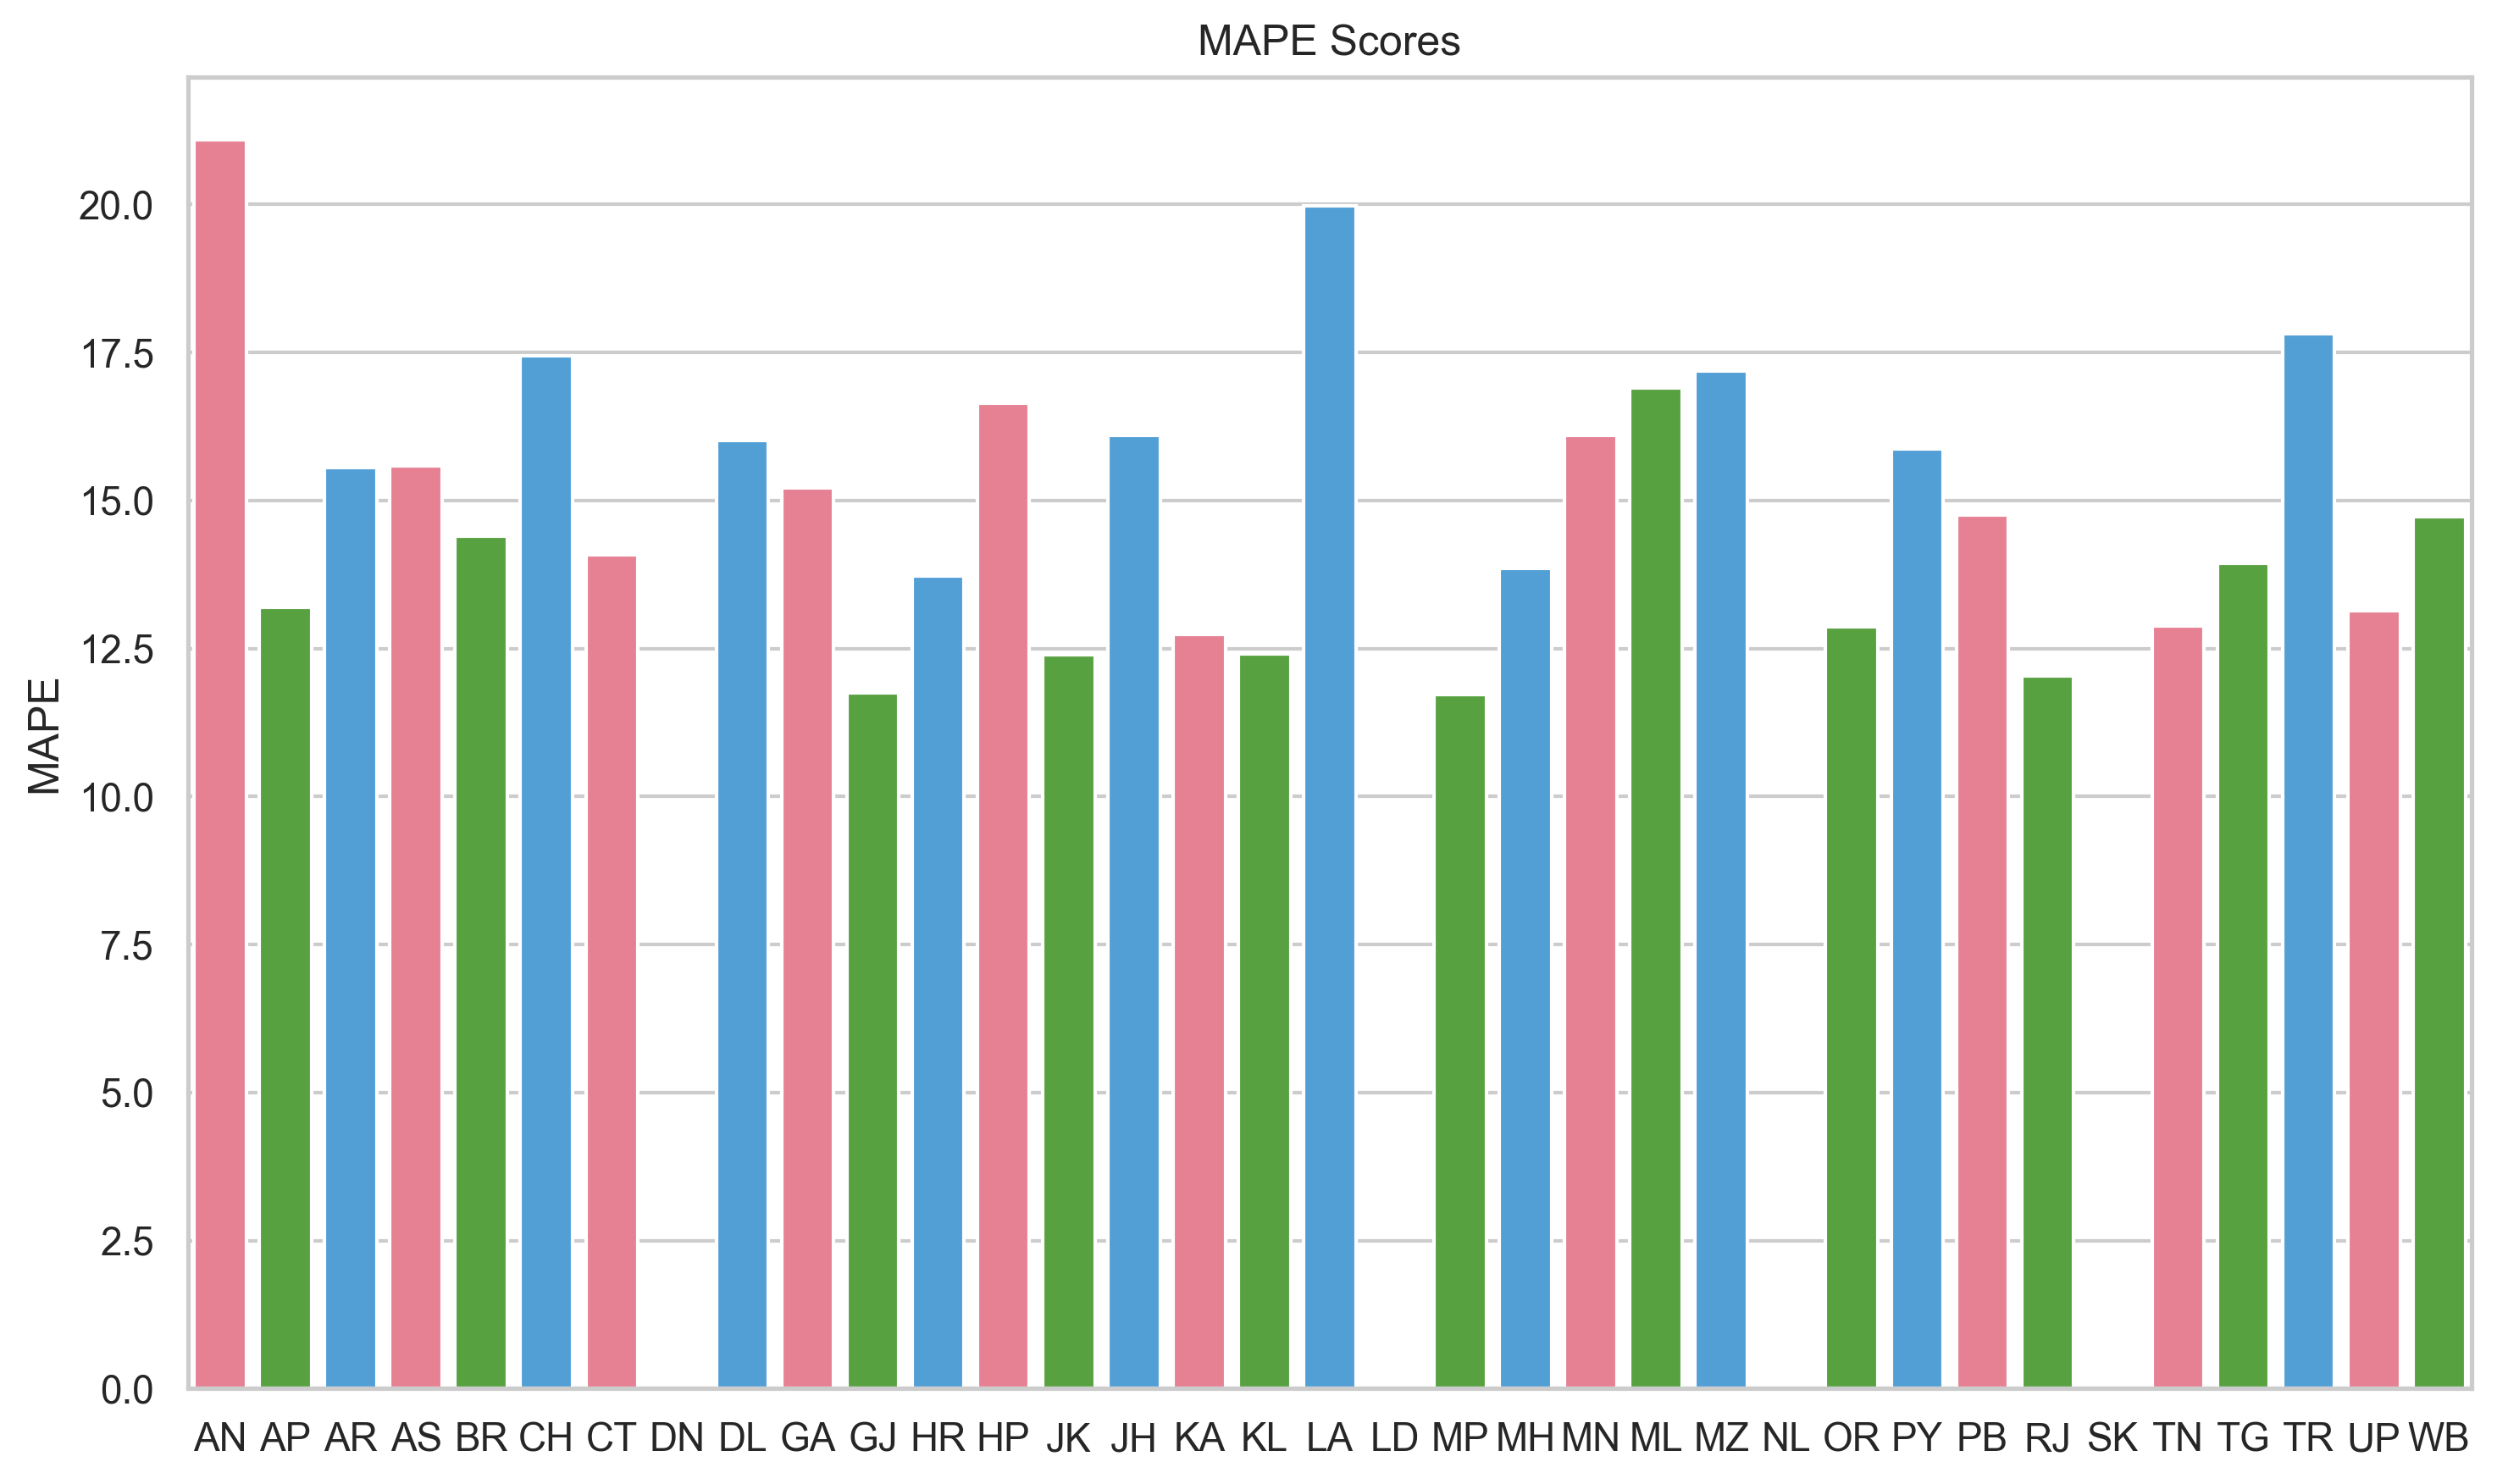

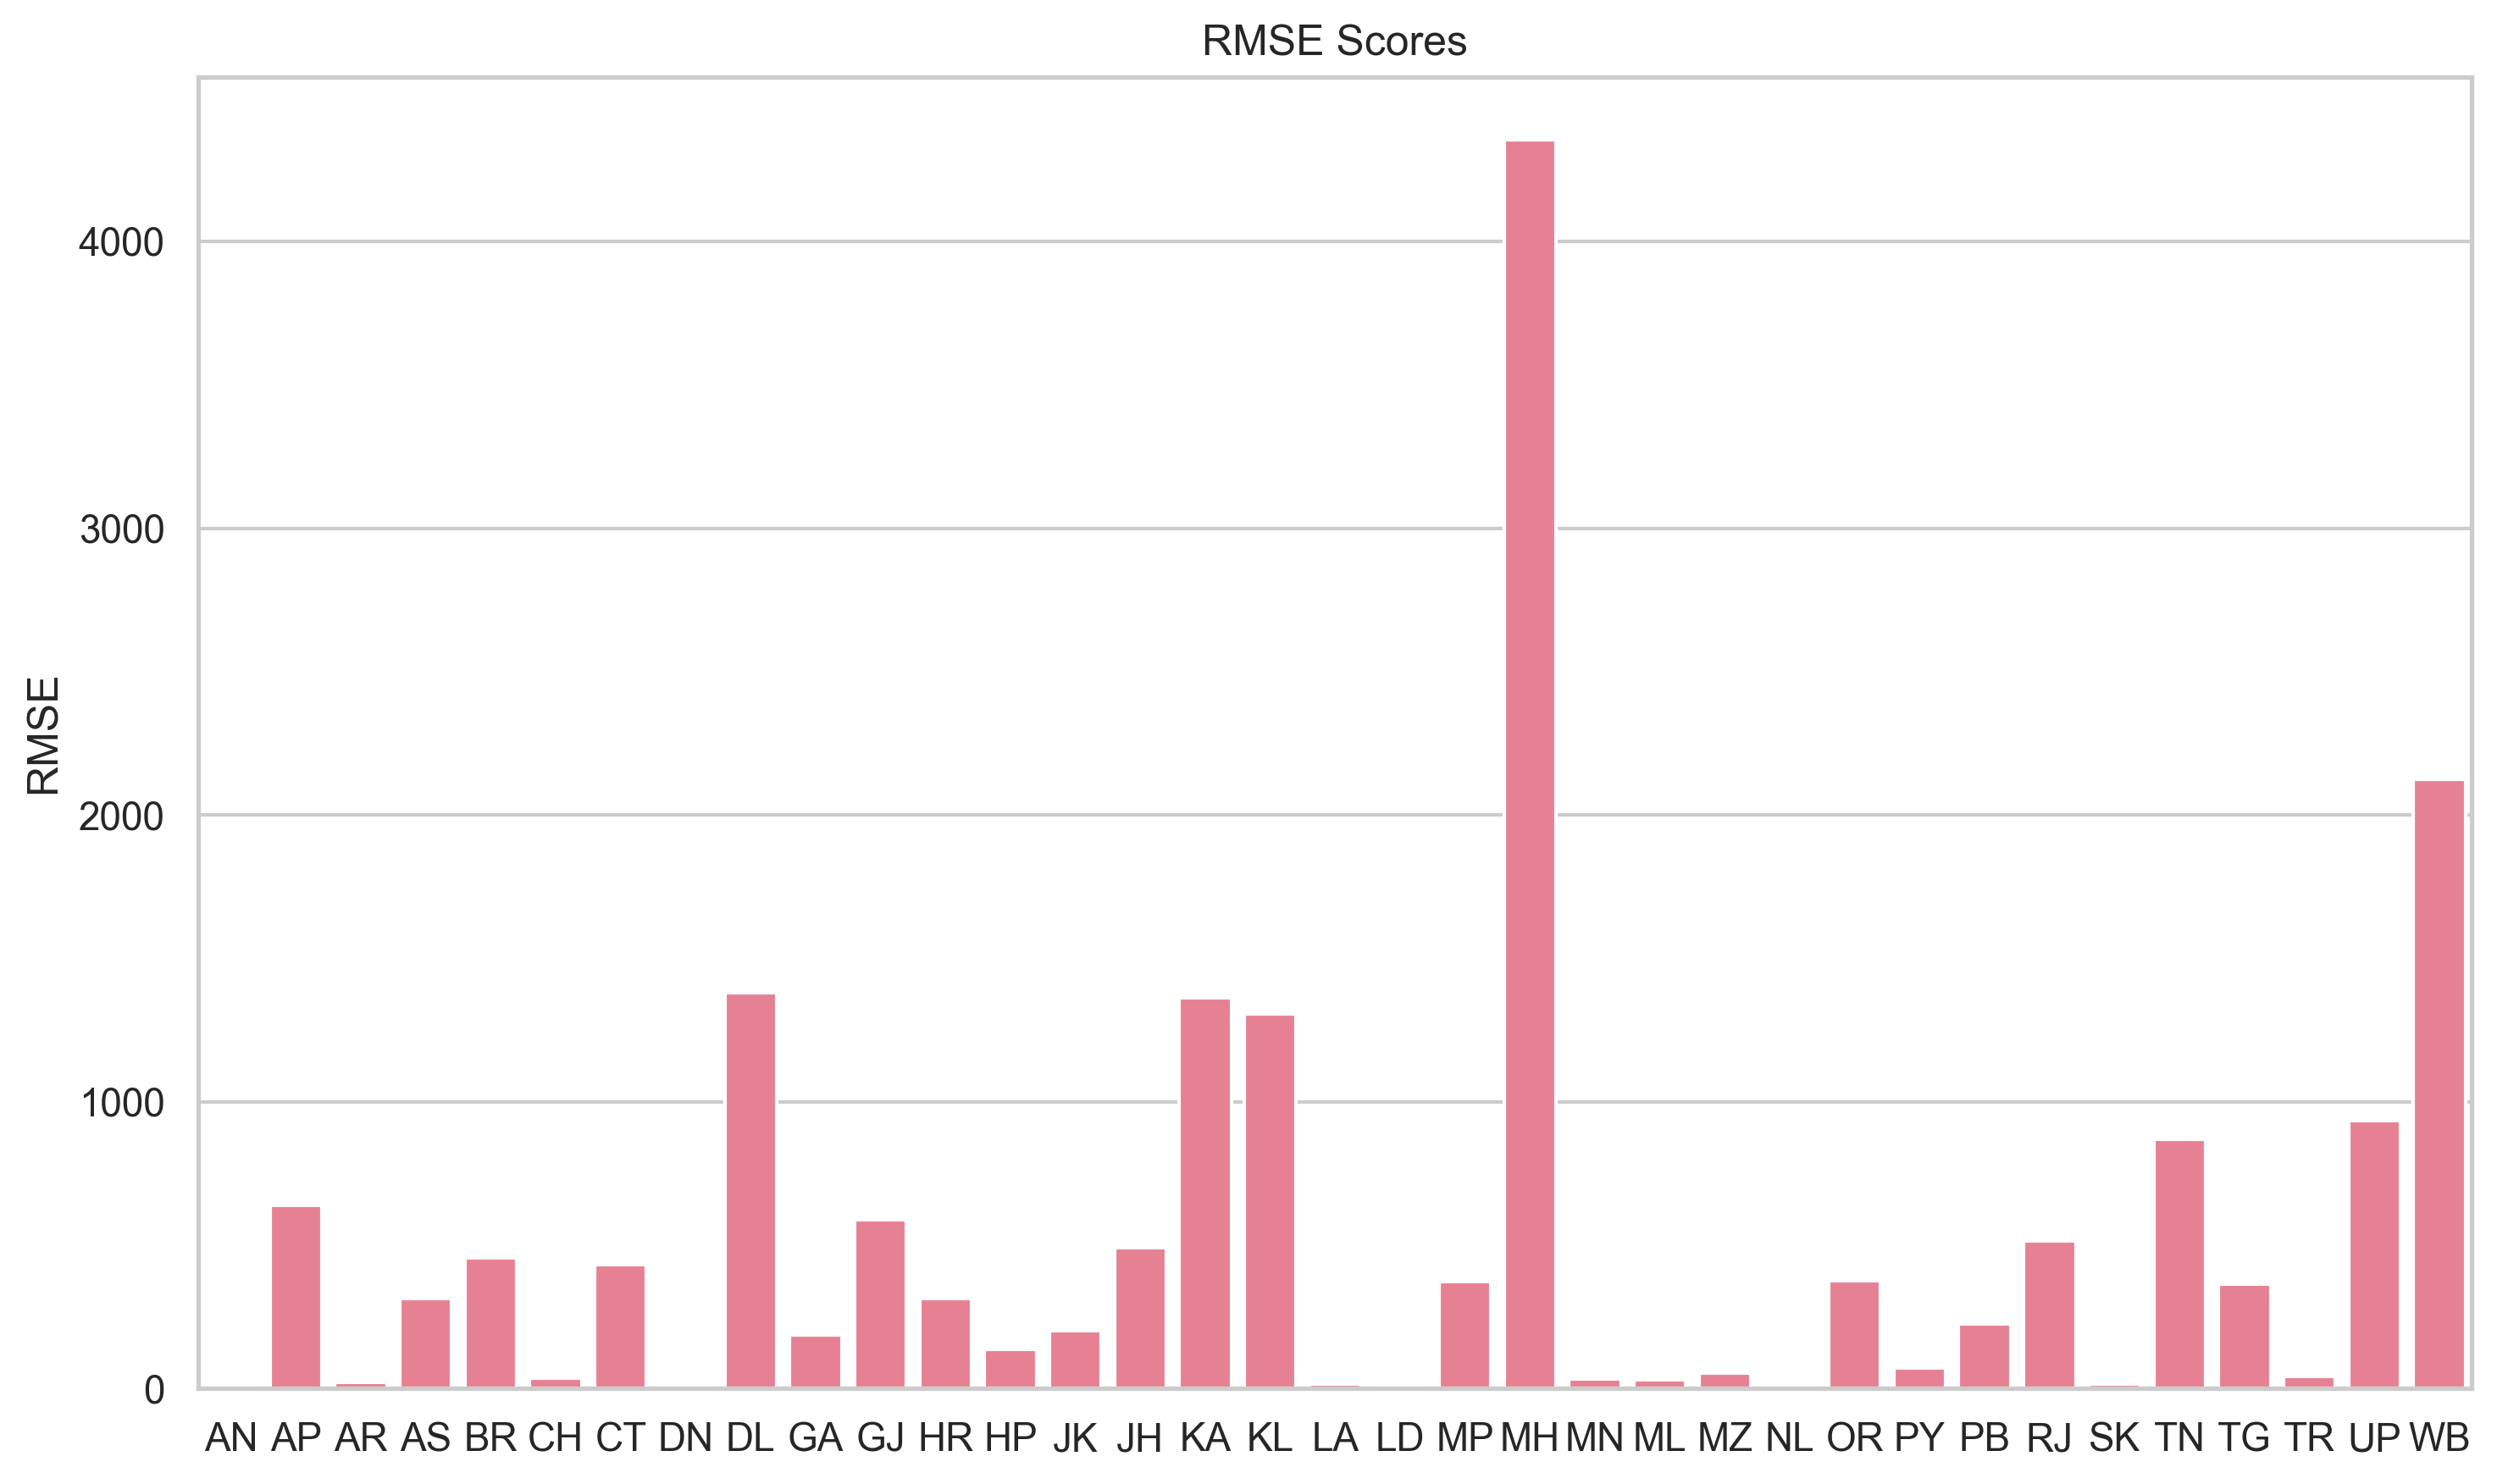

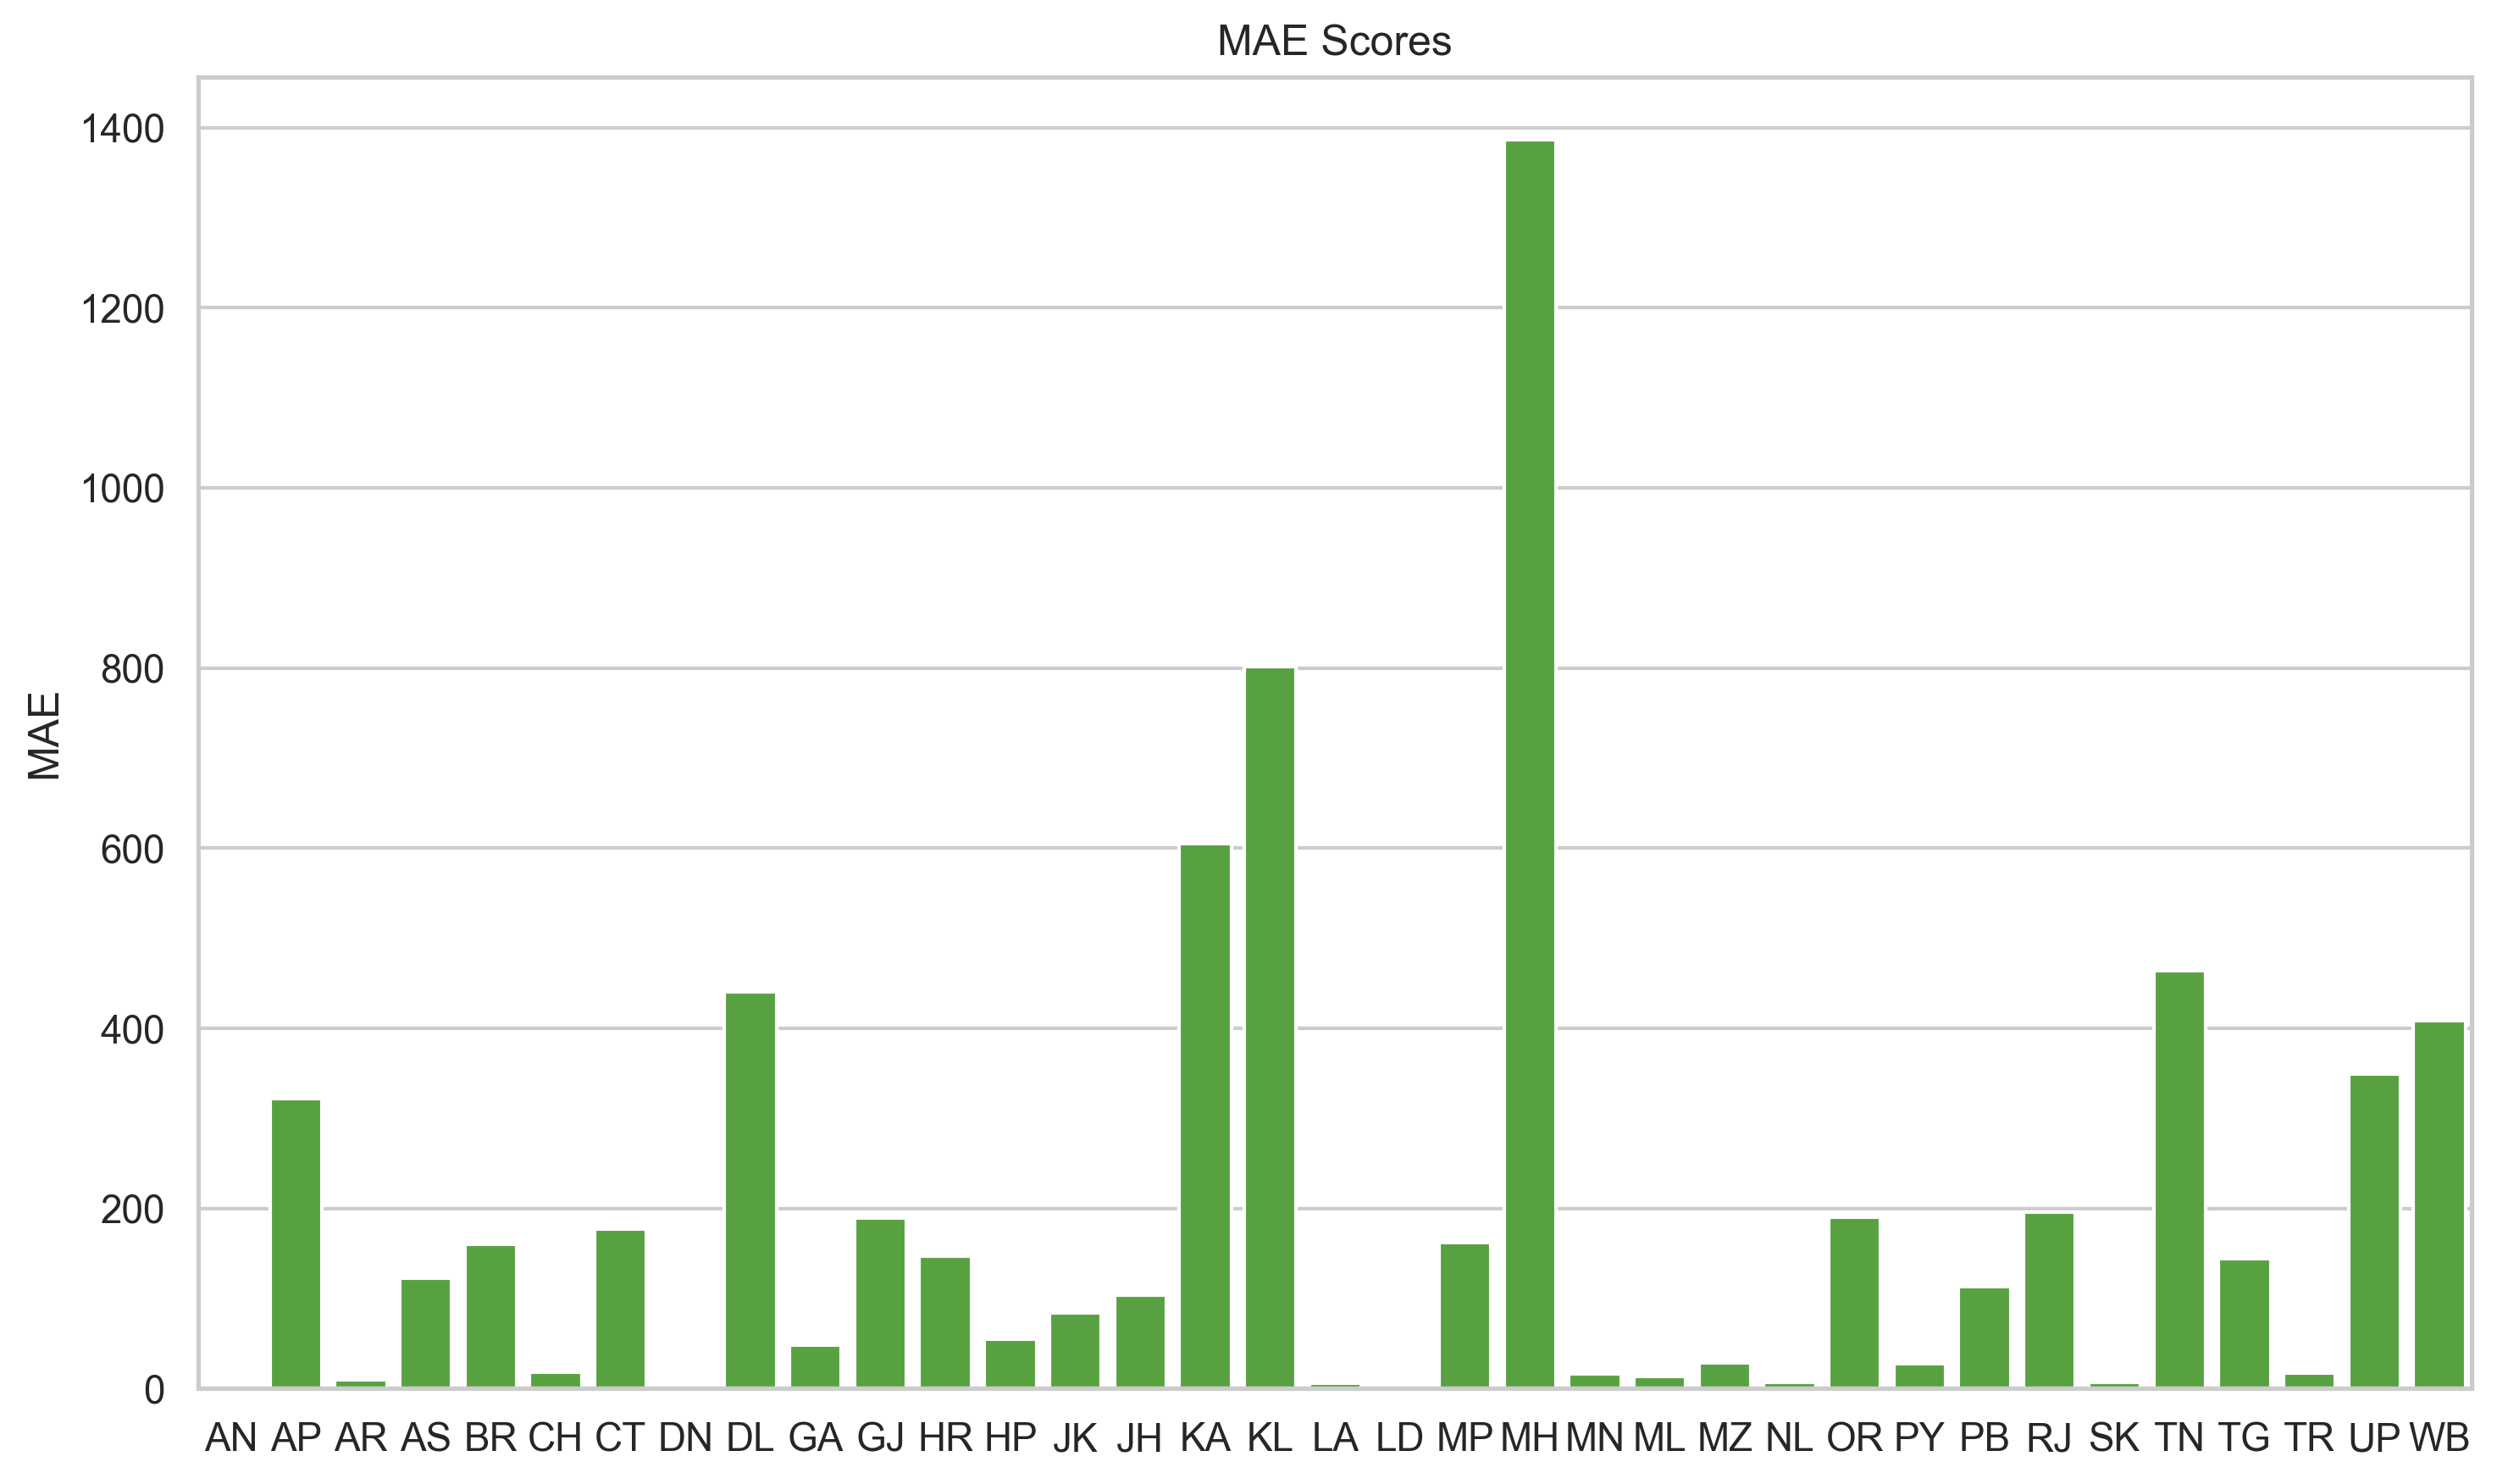

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_scores(df):
    # Define color palette for the plots
    colors = sns.color_palette("husl", 3)

    # Plot r2
    sns.set(style='whitegrid')
    fig1 = plt.figure(figsize=(10, 6), dpi=300)
    sns.barplot(x=df.index, y='r2', data=df, palette=colors)
    plt.xlabel('')
    plt.ylabel('r2')
    plt.title('R2 Scores')
    plt.tight_layout()
    plt.savefig('r2_scores.png')


    # Plot mape
    fig2 = plt.figure(figsize=(10, 6), dpi=300)
    sns.barplot(x=df.index, y='mape', data=df, palette=colors)
    plt.xlabel('')
    plt.ylabel('MAPE')
    plt.title('MAPE Scores')
    plt.tight_layout()


    # Plot rmse
    fig3 = plt.figure(figsize=(10, 6), dpi=300)
    sns.barplot(x=df.index, y='rmse', data=df, color=colors[0], label='RMSE')
    plt.xlabel('')
    plt.ylabel('RMSE')
    plt.title('RMSE Scores')
    plt.tight_layout()


    # Plot mae
    fig4 = plt.figure(figsize=(10, 6), dpi=300)
    sns.barplot(x=df.index, y='mae', data=df, color=colors[1], label='MAE')
    plt.xlabel('')
    plt.ylabel('MAE')
    plt.title('MAE Scores')
    plt.tight_layout()





In [21]:
!pip install seaborn

     -------------------------------------- 293.3/293.3 kB 2.0 MB/s eta 0:00:00


In [14]:
scores

,r squared,mae,mape,mse,rmse
AN,0.720450,2.387424,21.095445,4.932846e+01,7.023422
AP,0.961275,322.030178,13.194255,4.080922e+05,638.820915
AR,0.934381,9.593474,15.553601,4.879793e+02,22.090252
AS,0.890447,123.001080,15.591278,9.951906e+04,315.466416
BR,0.899912,159.965390,14.402064,2.083871e+05,456.494399
CH,0.912191,18.512548,17.438193,1.424960e+03,37.748636
CT,0.953527,177.628311,14.081189,1.865194e+05,431.878947
DN,0.870869,2.643647,inf,6.241985e+01,7.900623
DL,0.734800,440.895138,16.017509,1.905835e+06,1380.519943
GA,0.731527,48.154689,15.214412,3.473877e+04,186.383386


In [33]:
# Set some formatting options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 2)

# Print the dataframe
print(scores.to_string())

    r squared      mae   mape       mse     rmse
AN       0.72     2.39  21.10  4.93e+01     7.02
AP       0.96   322.03  13.19  4.08e+05   638.82
AR       0.93     9.59  15.55  4.88e+02    22.09
AS       0.89   123.00  15.59  9.95e+04   315.47
BR       0.90   159.97  14.40  2.08e+05   456.49
CH       0.91    18.51  17.44  1.42e+03    37.75
CT       0.95   177.63  14.08  1.87e+05   431.88
DN       0.87     2.64    inf  6.24e+01     7.90
DL       0.73   440.90  16.02  1.91e+06  1380.52
GA       0.73    48.15  15.21  3.47e+04   186.38
GJ       0.90   189.20  11.75  3.46e+05   588.19
HR       0.96   147.51  13.72  9.95e+04   315.38
HP       0.90    54.74  16.64  1.87e+04   136.66
JK       0.89    83.68  12.40  4.05e+04   201.26
JH       0.54   103.37  16.10  2.40e+05   490.30
KA       0.95   604.87  12.74  1.86e+06  1363.88
KL       0.97   801.31  12.41  1.71e+06  1306.98
LA       0.75     5.88  19.98  2.46e+02    15.69
LD       0.94     1.91    inf  4.18e+01     6.47
MP       0.95   162.

In [274]:
scores = Experiment.MAPE_full(daily_cases.iloc[:,t],y)*100

mape = PrettyTable(["State", "MAPE (%)"])
for scr in zip(states,scores):
    mape.add_row(scr)

print(mape)

+-------+--------------------+
| State |      MAPE (%)      |
+-------+--------------------+
|   AN  | 21.095445289923713 |
|   AP  | 13.19425508109798  |
|   AR  | 15.553599904266113 |
|   AS  | 15.591278127657313 |
|   BR  | 14.402064347715978 |
|   CH  | 17.438192797502754 |
|   CT  | 14.081189409600142 |
|   DN  | 21.88548659422482  |
|   DL  | 16.017508977892135 |
|   GA  | 15.21441147825349  |
|   GJ  | 11.754007490077163 |
|   HR  | 13.724457663463868 |
|   HP  | 16.64088567174653  |
|   JK  | 12.400348528256732 |
|   JH  | 16.098825088616927 |
|   KA  | 12.740192570506439 |
|   KL  | 12.405909256170753 |
|   LA  |  19.9781263270595  |
|   LD  |  9.60578391931839  |
|   MP  | 11.724085370742193 |
|   MH  | 13.852386000906098 |
|   MN  | 16.097659173797197 |
|   ML  | 16.89969468770332  |
|   MZ  | 17.18583880003398  |
|   NL  | 16.95402451119294  |
|   OR  | 12.865678298540125 |
|   PY  | 15.872924322809956 |
|   PB  | 14.761632417200207 |
|   RJ  | 12.034657204334321 |
|   SK  

In [40]:
y

array([[6.73943259e-01, 7.16147464e-01, 7.43854438e-01, ...,
        5.35518518e-01, 5.13112178e-01, 4.91271400e-01],
       [3.37735913e+01, 3.54614925e+01, 3.72888670e+01, ...,
        2.56549475e+01, 2.53687097e+01, 2.50888734e+01],
       [1.00028154e-02, 9.60054435e-03, 9.21080881e-03, ...,
        1.17850787e+00, 1.12919856e+00, 1.08113388e+00],
       ...,
       [7.21373023e-02, 7.34894929e-02, 7.87502480e-02, ...,
        8.81058413e+00, 8.74182218e+00, 8.67448217e+00],
       [5.22907673e+01, 5.45967024e+01, 5.69381226e+01, ...,
        5.47334582e+01, 5.38678007e+01, 5.30225033e+01],
       [1.90316260e+01, 2.00863285e+01, 2.10635777e+01, ...,
        6.49126998e+01, 6.29838996e+01, 6.11029612e+01]])

In [39]:
scores

,r2,mae,mape,mse,rmse
AN,0.720450,2.387424,21.095445,4.932846e+01,7.023422
AP,0.961275,322.030178,13.194255,4.080922e+05,638.820915
AR,0.934381,9.593474,15.553601,4.879793e+02,22.090252
AS,0.890447,123.001080,15.591278,9.951906e+04,315.466416
BR,0.899912,159.965390,14.402064,2.083871e+05,456.494399
CH,0.912191,18.512548,17.438193,1.424960e+03,37.748636
CT,0.953527,177.628311,14.081189,1.865194e+05,431.878947
DN,0.870869,2.643647,inf,6.241985e+01,7.900623
DL,0.734800,440.895138,16.017509,1.905835e+06,1380.519943
GA,0.731527,48.154689,15.214412,3.473877e+04,186.383386


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (35,) and arg 1 with shape (35, 5).

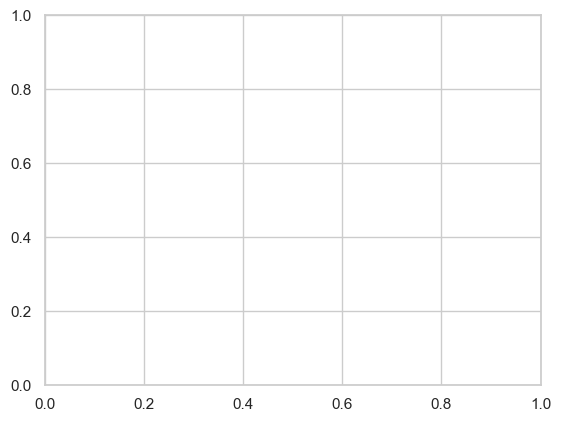

In [38]:


plt.bar(range(len(states)), scores, tick_label=states)
ax = plt.gca()
ax.set_xticklabels(states,rotation=90)
plt.xlabel("States")
plt.ylabel("MAPE(%)")
plt.title("MAPE(%) DayWise Data ")
plt.show()

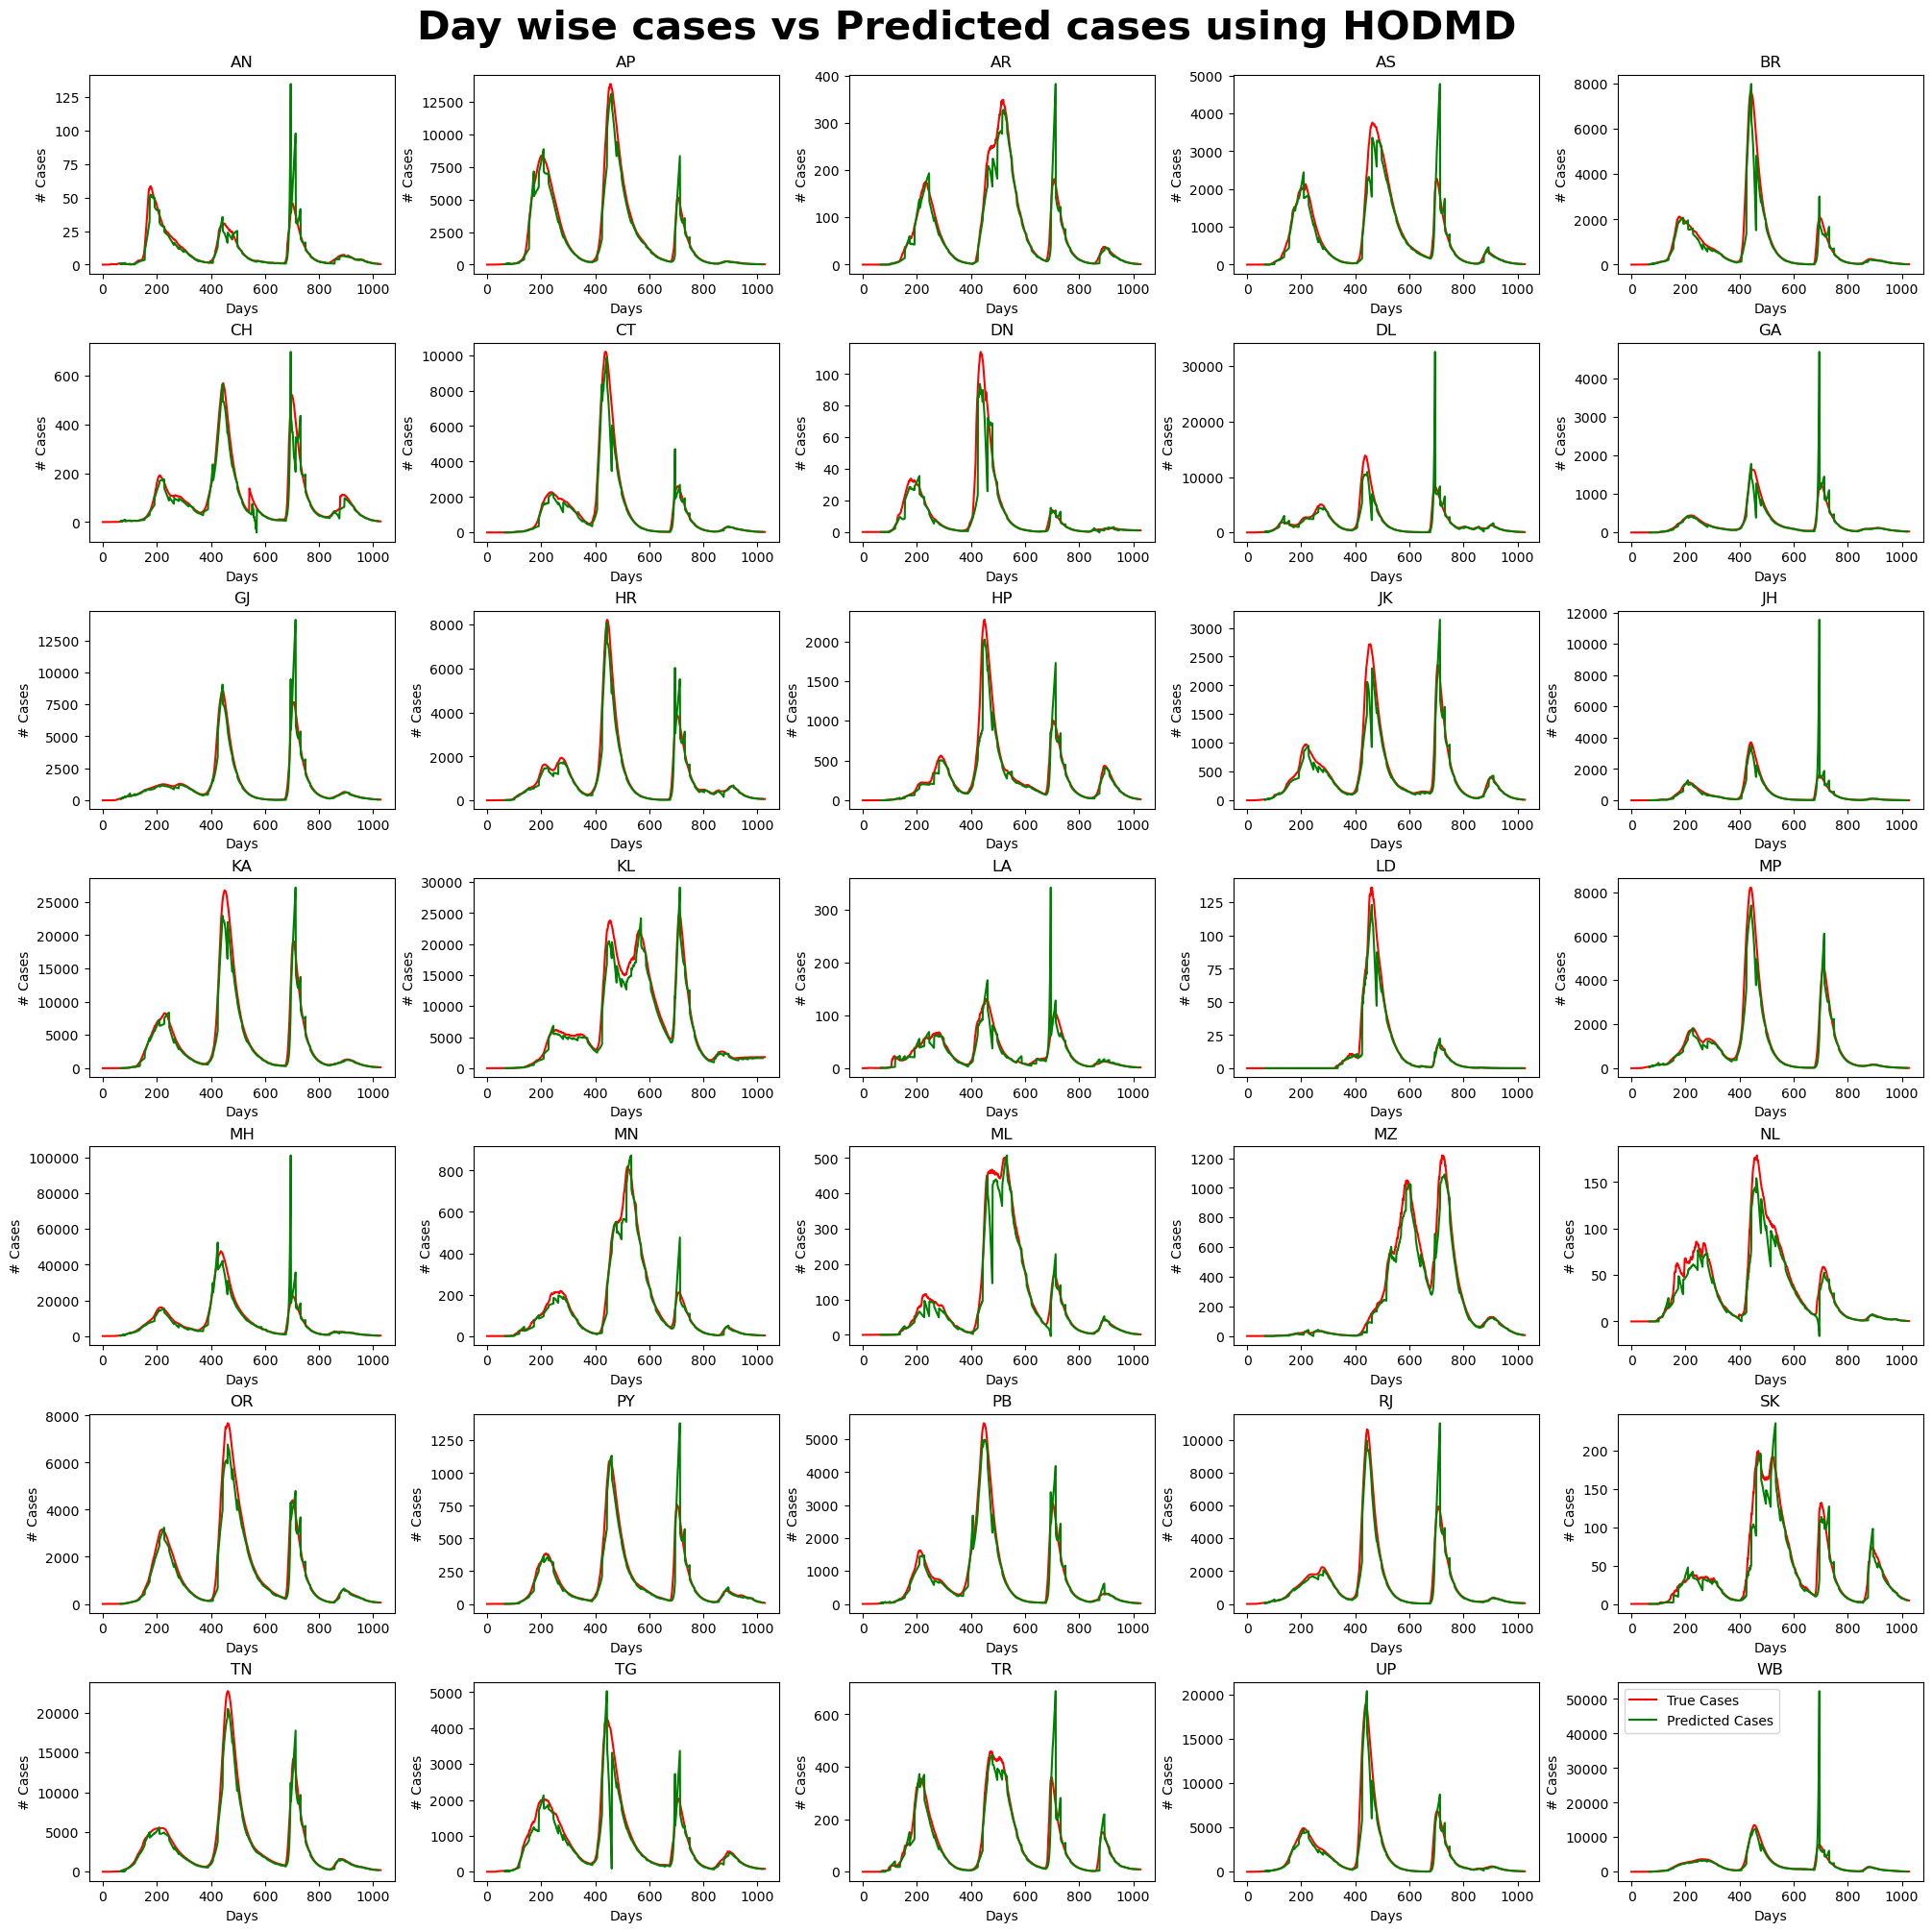

In [275]:
#Figure 
fig = plt.figure(figsize=(20,20), constrained_layout=True)
gs = fig.add_gridspec(nrows=7,ncols=5)


fig.suptitle("Day wise cases vs Predicted cases using HODMD",fontweight='bold',fontsize=30)

for row_ in range(7):
    for col_ in range(5):
        idx = 5*row_ + col_
        state = states[idx]
        ax = fig.add_subplot(gs[row_,col_])
        ax.set_title(f"{state}")
        ax.set_xlabel("Days")
        ax.set_ylabel("# Cases")

        ax.plot(daily_cases.iloc[idx,:],'-r')
        ax.plot(t,y[idx,:],'-g')



plt.legend(["True Cases", "Predicted Cases"])


plt.show()

(35, 1028)

In [135]:
import pandas as pd
start_date = pd.to_datetime("2020-01-30")
end_date = start_date + pd.DateOffset(days=daily_cases.shape[1]-1)
dates = pd.date_range(start_date, end_date)

dates

DatetimeIndex(['2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08',
               ...
               '2022-11-13', '2022-11-14', '2022-11-15', '2022-11-16',
               '2022-11-17', '2022-11-18', '2022-11-19', '2022-11-20',
               '2022-11-21', '2022-11-22'],
              dtype='datetime64[ns]', length=1028, freq='D')

<AxesSubplot: >

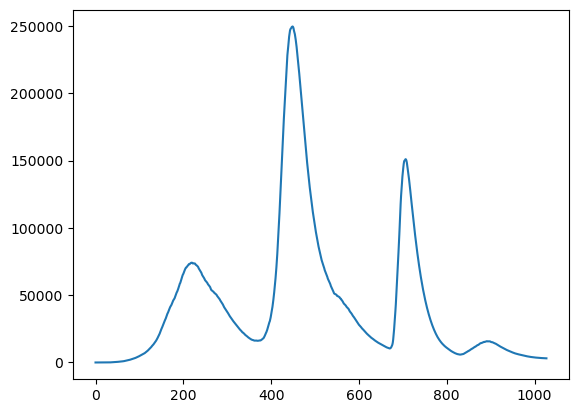

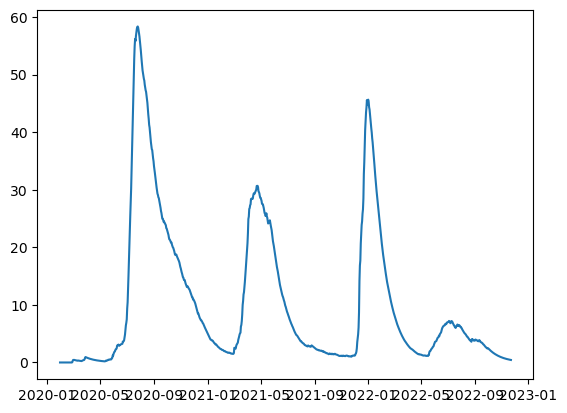

In [136]:
plt.plot(dates,daily_cases.iloc[0,:])


# Cum Cases

In [288]:
cum_cases = daily_cases.cumsum(axis=1)
cum_cases.shape

(35, 1028)

In [289]:


def cum_objective(trial:Trial,lam=0.5,return_info=False):
    train_days = trial.suggest_int("train_days",20,150)
    pred_days = trial.suggest_int("pred_days",15,60)
    d = trial.suggest_int("d",3,train_days-2)
    t,y,exps,lambdas = sliding_pred(cum_cases,train_days=train_days,pred_days=pred_days,d=d)
    score = ((1-lam)* Experiment.MAPE_full(cum_cases.iloc[:, t],y).sum()) + lam*(train_days/pred_days)

    if return_info:
        return score,t,y,exps, lambdas
    else:
        return score

study = optuna.create_study()
study.optimize(cum_objective, n_trials=250,n_jobs=-1)


[I 2023-01-18 07:45:01,250] A new study created in memory with name: no-name-d2d50f8c-a1d2-4282-8910-90071037bbd2
[I 2023-01-18 07:45:06,215] Trial 4 finished with value: 15.426849012607569 and parameters: {'train_days': 44, 'pred_days': 52, 'd': 18}. Best is trial 4 with value: 15.426849012607569.
[I 2023-01-18 07:45:07,999] Trial 9 finished with value: 393.5542956570589 and parameters: {'train_days': 64, 'pred_days': 47, 'd': 54}. Best is trial 4 with value: 15.426849012607569.
[I 2023-01-18 07:45:08,351] Trial 7 finished with value: 9.064073120843148 and parameters: {'train_days': 51, 'pred_days': 31, 'd': 13}. Best is trial 7 with value: 9.064073120843148.
[I 2023-01-18 07:45:10,263] Trial 13 finished with value: 1584221.6204164247 and parameters: {'train_days': 100, 'pred_days': 41, 'd': 7}. Best is trial 7 with value: 9.064073120843148.
[I 2023-01-18 07:45:11,086] Trial 5 finished with value: 3.962405086344699 and parameters: {'train_days': 39, 'pred_days': 18, 'd': 15}. Best is 

In [290]:
study.best_params

{'train_days': 141, 'pred_days': 59, 'd': 78}

In [291]:
t,y,exps,lambdas = sliding_pred(cum_cases,**study.best_params)

In [292]:
scores = Experiment.MAPE_full(cum_cases.iloc[:,t],y)*100

mape = PrettyTable(["State", "MAPE (%)"])
for scr in zip(states,scores):
    mape.add_row(scr)

print(mape)

+-------+--------------------+
| State |      MAPE (%)      |
+-------+--------------------+
|   AN  | 11.673417443536117 |
|   AP  | 8.824265436565014  |
|   AR  | 5.0461423033796535 |
|   AS  | 6.719046459461405  |
|   BR  | 7.737721129058637  |
|   CH  | 8.515044949241021  |
|   CT  |  8.94396594422822  |
|   DN  | 7.507185667654196  |
|   DL  |  8.97856634236105  |
|   GA  | 6.358829538209841  |
|   GJ  | 10.949995236190382 |
|   HR  | 7.189374606272311  |
|   HP  |  9.81058472715291  |
|   JK  | 7.687049530502541  |
|   JH  | 7.673168566482384  |
|   KA  | 7.415978280354032  |
|   KL  | 6.901351556750641  |
|   LA  | 10.508970121533629 |
|   LD  | 10.74669816491166  |
|   MP  | 9.179515753861974  |
|   MH  | 7.598530725887861  |
|   MN  | 5.355563835136412  |
|   ML  | 7.187266490679307  |
|   MZ  | 13.280627979675161 |
|   NL  | 10.45183395783423  |
|   OR  | 7.640515021109147  |
|   PY  | 8.830682131819492  |
|   PB  | 7.800883141428577  |
|   RJ  | 7.577036626514257  |
|   SK  

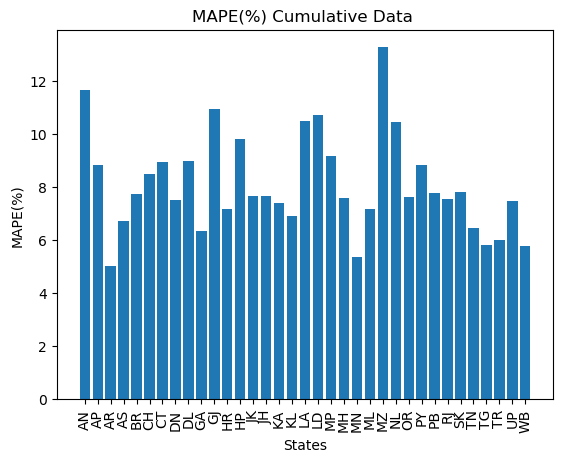

In [293]:

plt.bar(range(len(states)), scores, tick_label=states)
ax = plt.gca()
ax.set_xticklabels(states,rotation=90)
plt.xlabel("States")
plt.ylabel("MAPE(%)")
plt.title("MAPE(%) Cumulative Data ")
plt.show()

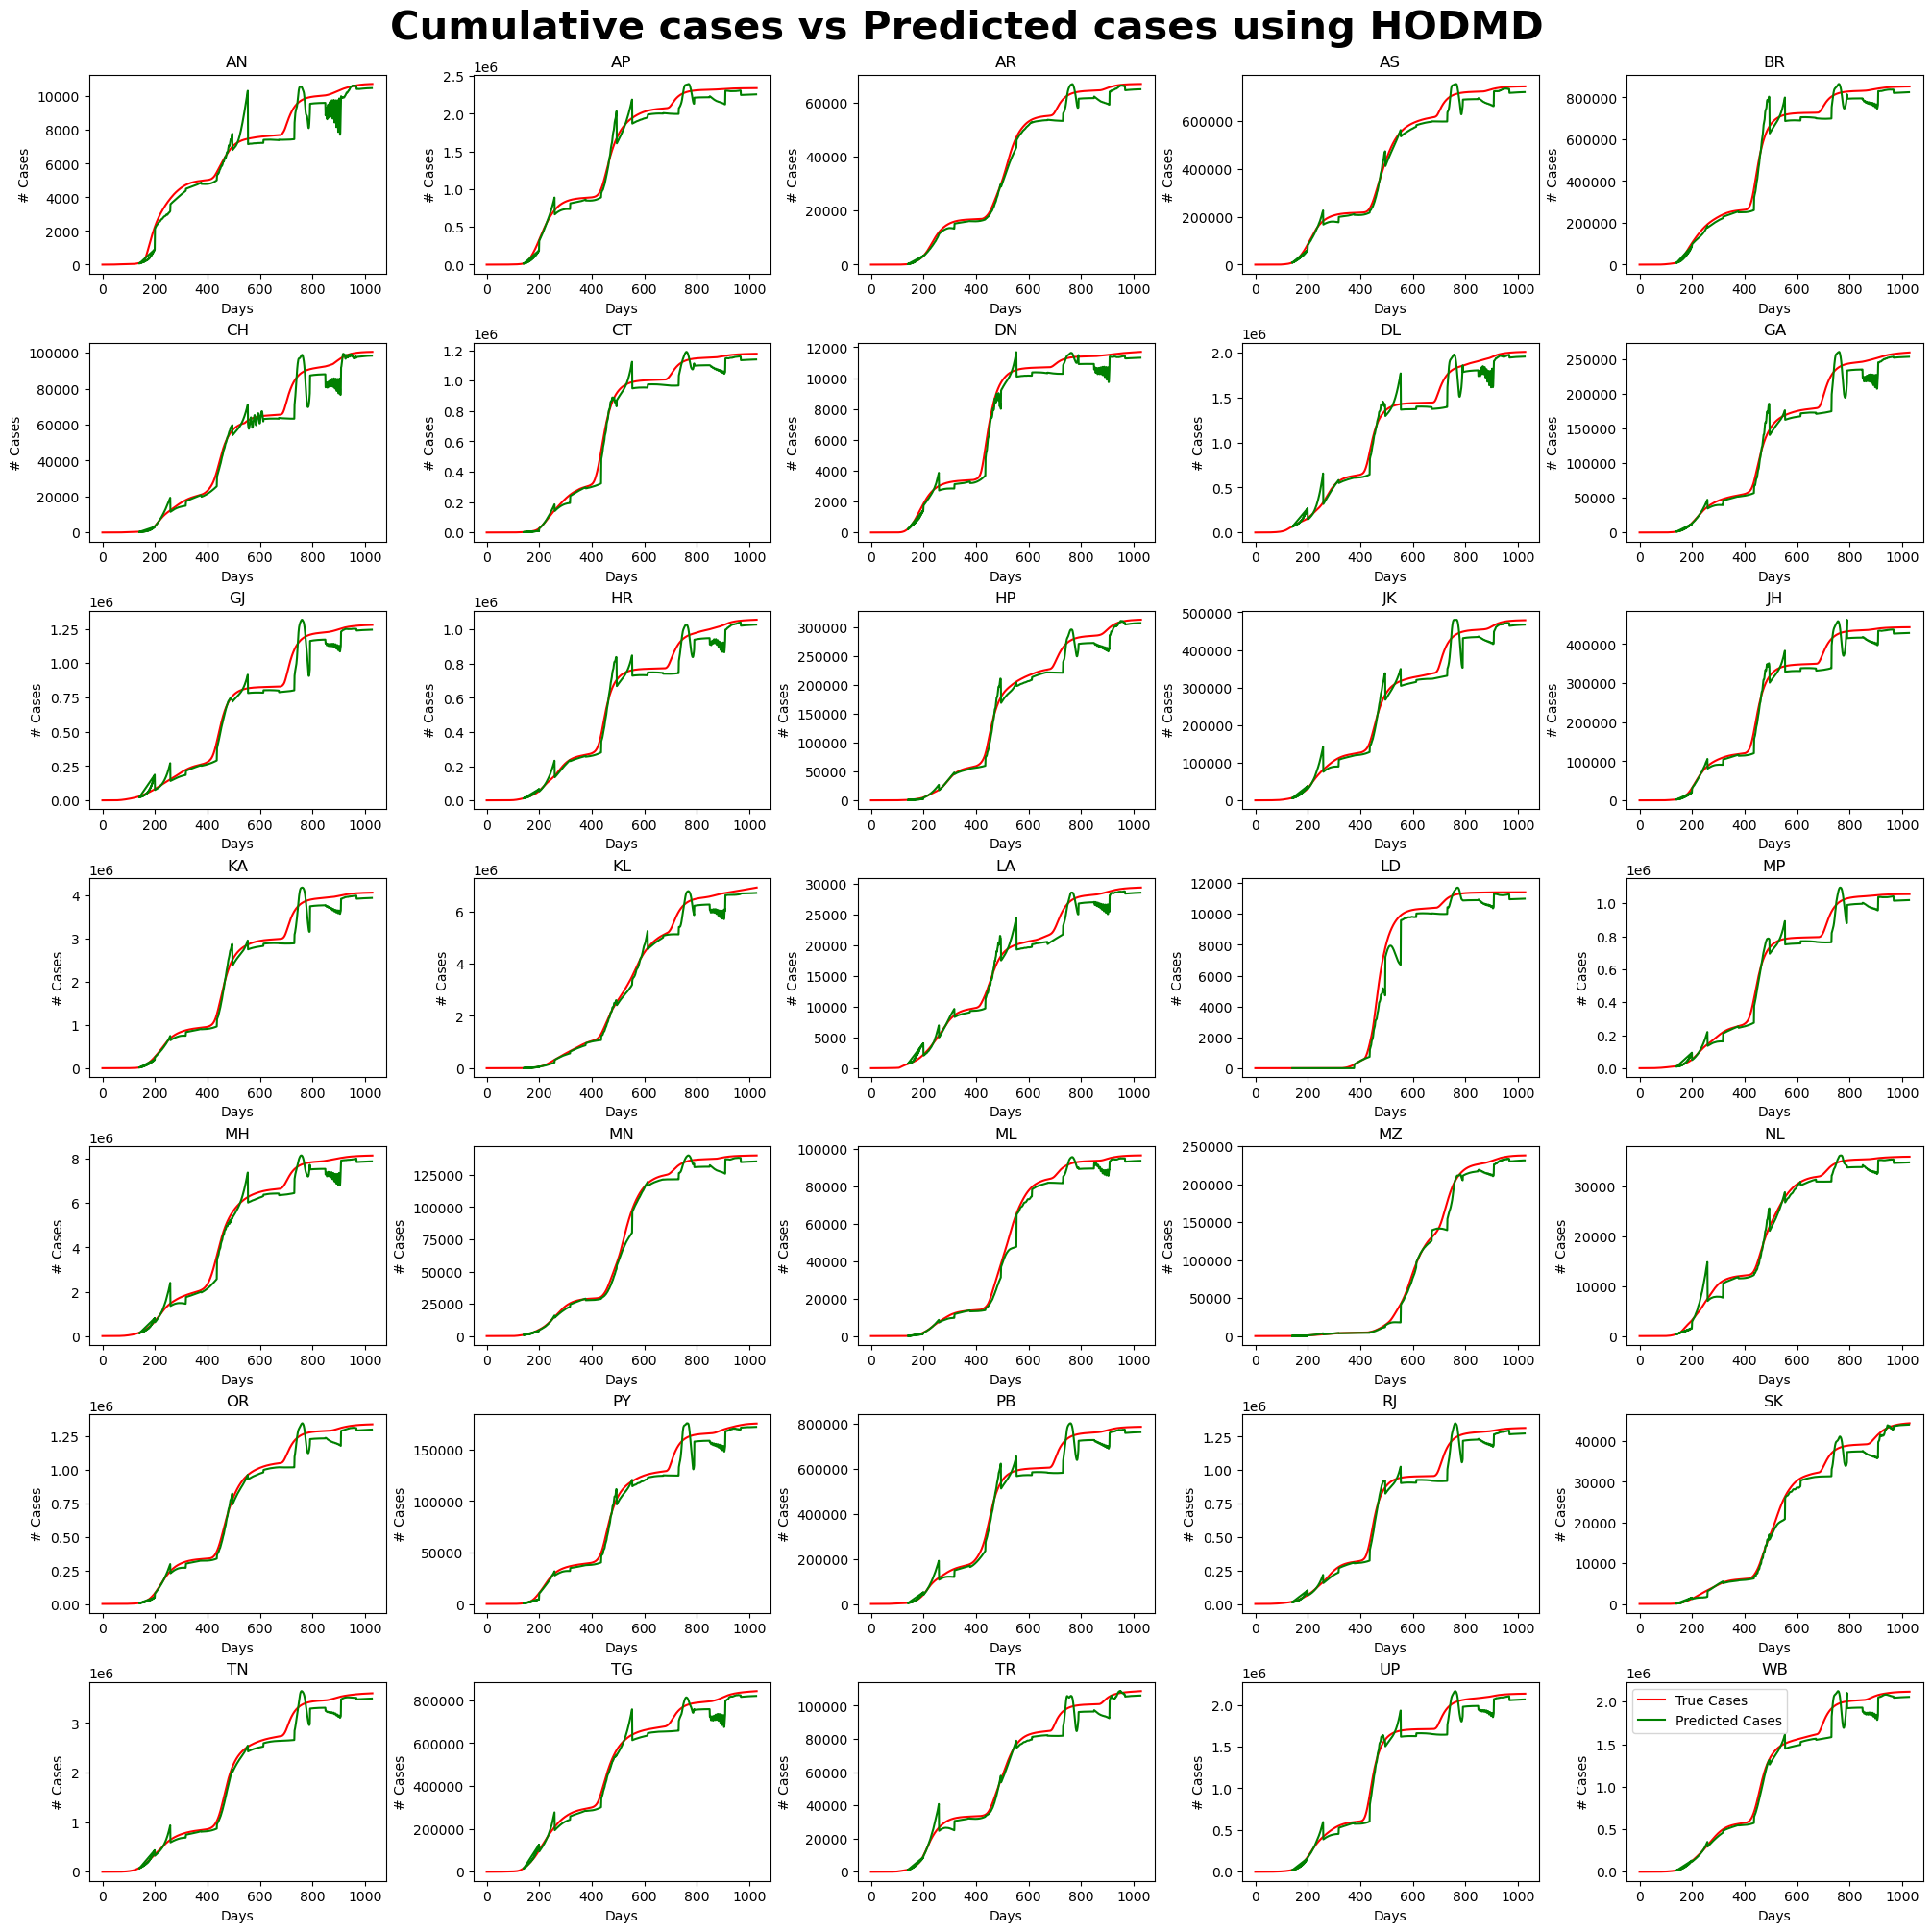

In [312]:
#Figure 
fig = plt.figure(figsize=(20,20), constrained_layout=True)
gs = fig.add_gridspec(nrows=7,ncols=5)


fig.suptitle("Cumulative cases vs Predicted cases using HODMD",fontweight='bold',fontsize=30)

for row_ in range(7):
    for col_ in range(5):
        idx = 5*row_ + col_
        state = states[idx]
        ax = fig.add_subplot(gs[row_,col_])
        ax.set_title(f"{state}")
        ax.set_xlabel("Days")
        ax.set_ylabel("# Cases")

        ax.plot(cum_cases.iloc[idx,:],'-r')
        ax.plot(t,y[idx,:],'-g')



plt.legend(["True Cases", "Predicted Cases"])


plt.show()

In [183]:
study.best_params

{'train_days': 138, 'pred_days': 59, 'd': 99}

In [196]:
i=1
138+i*59

197

In [200]:

i=1
np.arange(study.best_params["train_days"]+study.best_params["pred_days"] , study.best_params["train_days"] + 2*study.best_params["pred_days"])

(59,)

In [194]:
exps[0].pred()[0,:].shape

(59,)

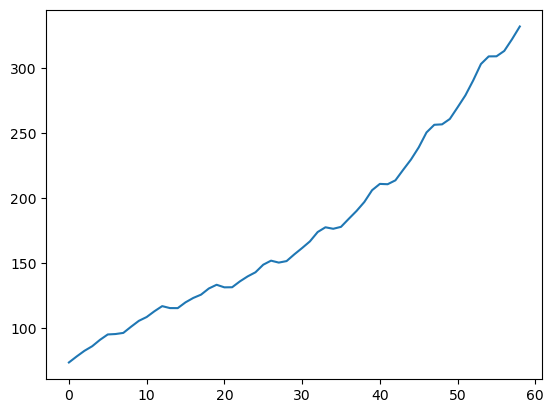

In [191]:
plt.plot()

Text(0, 0.5, '# Cases')

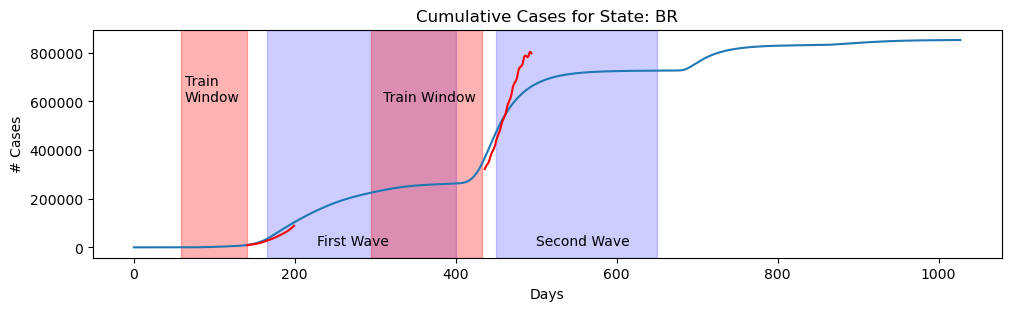

In [311]:
fig = plt.figure(figsize=(10,3), constrained_layout=True)
gs = fig.add_gridspec(nrows=1,ncols=1)
ax1 = fig.add_subplot(gs[0,0])

ax1.plot(cum_cases.iloc[4,:])
plt.axvspan(165,400,alpha=0.2,color='blue')
plt.annotate("First Wave",(227,10000))

plt.axvspan(450,650,alpha=0.2,color='blue')
plt.annotate("Second Wave",(500,10000))

#ax1.plot(np.arange(study.best_params["train_days"]+study.best_params["pred_days"] , study.best_params["train_days"] + 2*study.best_params["pred_days"]), 
#exps[1].pred()[0,:],
#'r-'
#)

i=1
ax1.plot(t[i*59:(i+1)*59],y[4,i*59:(i+1)*59],'r-')


j=6
ax1.plot(t[j*59:(j+1)*59],y[4,j*59:(j+1)*59],'r-')

plt.axvspan(5*59,433,alpha=0.3,color='red')
plt.annotate("Train Window",(310,600000))


plt.axvspan(59,3*59-37,alpha=0.3,color='red')
plt.annotate("Train \nWindow",(63,600000))

plt.title("Cumulative Cases for State: BR")
plt.xlabel("Days")
plt.ylabel("# Cases")



In [298]:
states

Index(['AN', 'AP', 'AR', 'AS', 'BR', 'CH', 'CT', 'DN', 'DL', 'GA', 'GJ', 'HR',
       'HP', 'JK', 'JH', 'KA', 'KL', 'LA', 'LD', 'MP', 'MH', 'MN', 'ML', 'MZ',
       'NL', 'OR', 'PY', 'PB', 'RJ', 'SK', 'TN', 'TG', 'TR', 'UP', 'WB'],
      dtype='object')

In [217]:
t_,y_,exps_,lambdas_ = sliding_pred(cum_cases.iloc[:,:210],**study.best_params)



In [225]:
138+59

197

In [226]:
197+59

256

In [229]:
t[2*59:3*59]

(59,)

array([ 138,  139,  140,  141,  142,  143,  144,  145,  146,  147,  148,
        149,  150,  151,  152,  153,  154,  155,  156,  157,  158,  159,
        160,  161,  162,  163,  164,  165,  166,  167,  168,  169,  170,
        171,  172,  173,  174,  175,  176,  177,  178,  179,  180,  181,
        182,  183,  184,  185,  186,  187,  188,  189,  190,  191,  192,
        193,  194,  195,  196,  138,  139,  140,  141,  142,  143,  144,
        145,  146,  147,  148,  149,  150,  151,  152,  153,  154,  155,
        156,  157,  158,  159,  160,  161,  162,  163,  164,  165,  166,
        167,  168,  169,  170,  171,  172,  173,  174,  175,  176,  177,
        178,  179,  180,  181,  182,  183,  184,  185,  186,  187,  188,
        189,  190,  191,  192,  193,  194,  195,  196,  197,  198,  199,
        200,  201,  202,  203,  204,  205,  206,  207,  208,  209,  210,
        211,  212,  213,  214,  215,  216,  217,  218,  219,  220,  221,
        222,  223,  224,  225,  226,  227,  228,  2

In [223]:
944/59

16.0

In [221]:
y[0]

array([   73.53964717,    78.16515973,    82.51178199,    86.04840578,
          90.95488691,    95.09694796,    95.42827595,    96.28813119,
         101.0543587 ,   105.57506106,   108.4971929 ,   112.93460419,
         116.88989596,   115.38005704,   115.35276958,   119.79749655,
         123.18625228,   125.72867089,   130.45322829,   133.31896585,
         131.34078339,   131.41370222,   135.93907193,   139.78083098,
         142.92684963,   148.76124107,   151.86350946,   150.37551426,
         151.54024968,   156.7393236 ,   161.58850992,   166.67630633,
         173.88894658,   177.54405293,   176.3865927 ,   177.87333056,
         184.05935899,   190.10464309,   196.98931871,   206.076053  ,
         210.91887195,   210.66674472,   213.66157015,   221.77038202,
         229.64531857,   239.02718565,   250.50939552,   256.39067489,
         256.7252577 ,   260.86878494,   269.84681416,   279.01728231,
         290.46063071,   303.13608978,   309.00708879,   309.07311126,
      

In [219]:
len(exps)

15

In [218]:
t_

array([138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196])

In [205]:
t_.shape

(59,)

IndexError: index 16 is out of bounds for axis 0 with size 12

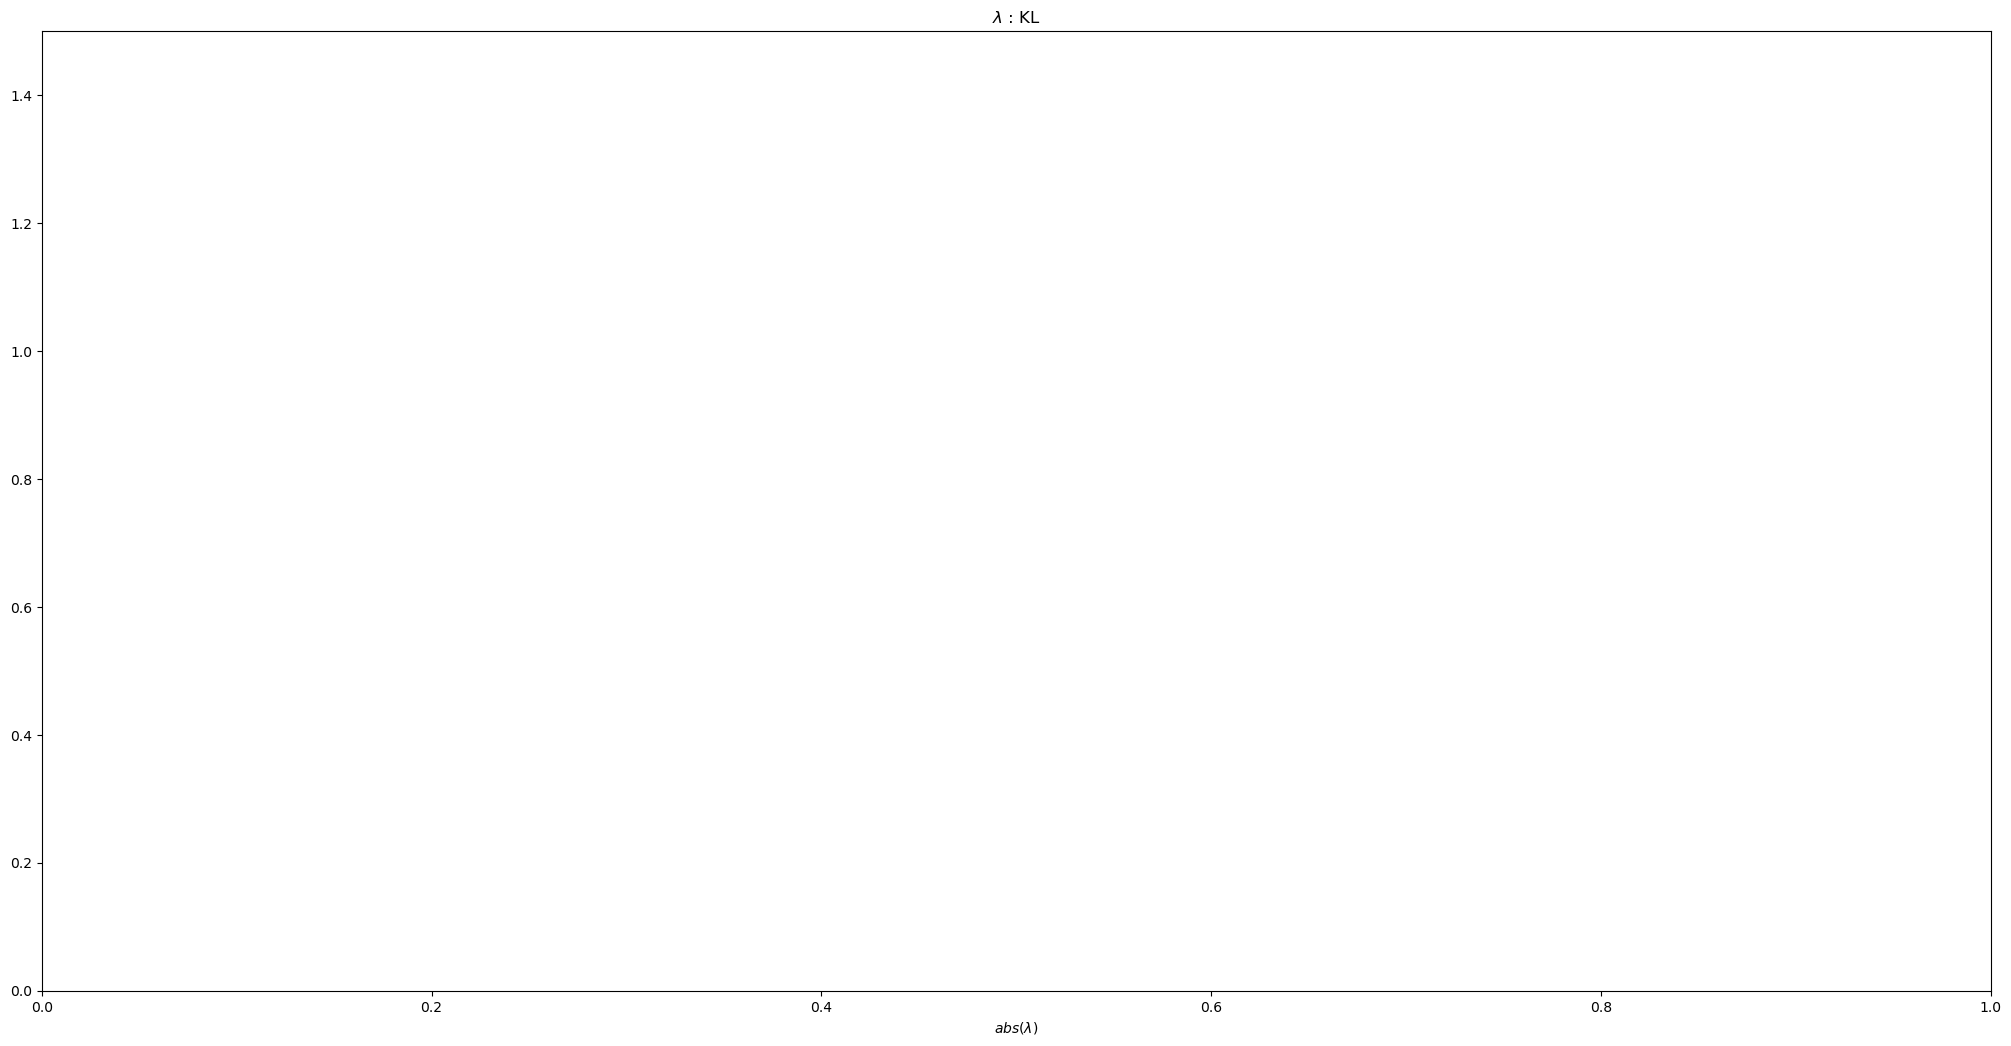

In [25]:
from matplotlib.animation import FuncAnimation

pred_timesteps = t
preds = y

state_list = states.to_list()
state="KL"
idx = state_list.index(state)

fig = plt.figure(figsize=(20,20), constrained_layout=True)
gs = fig.add_gridspec(nrows=2,ncols=1)

ax1 = fig.add_subplot(gs[1,0])
ax1.set_title(f"$\lambda$ : {state}")
ax1.set_ylim([0,1.5])
ax1.set_xlabel("$abs(\lambda)$")
ax1.plot(t,np.abs(lambdas)[idx,:])
ax1.plot(t,[1]*len(t),'r:')




ax2 = fig.add_subplot(gs[0,0])
ax2.set_title(f"Covid Cases : {state}")
ax2.set_xlim([0,1023])
ax2.set_ylim([0, daily_cases.loc[state,:].max()+100])
ax2.plot(daily_cases.loc[state,:])
ax2.set_xlabel("Days")
ax2.set_ylabel("Number of Cases")





In [88]:
Experiment.MAPE_full(cum_cases.iloc[:,t],y)*100

array([12.53361349,  6.86926607,  4.59443471,  5.41198029,  4.81496405,
        6.60313438,  5.15130409,  5.39133634,  5.91785831,  6.14882635,
        6.6955674 ,  5.69331228,  6.52608675,  6.17082544,  6.97542043,
        4.58668114,  6.84455404,  8.5249627 ,  9.39624959,  6.13938464,
        5.65898202,  5.81029477, 11.03903017,  9.95951311,  7.41000579,
        7.95576161,  8.01831346,  6.97882841,  5.89167391,  5.24074483,
        5.45869673,  5.31737535,  5.92687013,  6.36929936,  4.75757239])

In [37]:
lambdas.shape

(11, 972)

IndexError: index 16 is out of bounds for axis 0 with size 11

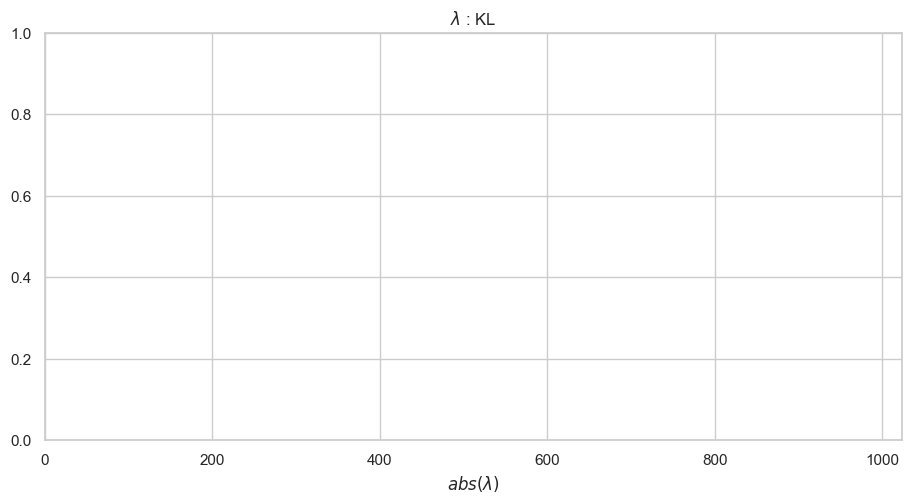

In [35]:
state="KL"
pred_timesteps = t
preds = y

state_list = states.to_list()
idx = state_list.index(state)
fig = plt.figure(figsize=(9,9), constrained_layout=True)
gs = fig.add_gridspec(nrows=2,ncols=1)
ax1 = fig.add_subplot(gs[1,0])
ax1.set_title(f"$\lambda$ : {state}")
ax1.set_xlim([0,1023])
ax1.set_xlabel("$abs(\lambda)$")
mag = np.abs(lambdas[idx,:])

plt.plot(t,np.power(mag,32))
# ax1.plot(t,[1]*len(t),'r:')




ax2 = fig.add_subplot(gs[0,0])
ax2.set_title(f"Covid Cases : {state}")
ax2.set_xlim([0,1023])
ax2.set_ylim([0, cum_cases.loc[state,:].max()+100])
ax2.plot(cum_cases.loc[state,:])
ax2.set_xlabel("Days")
ax2.set_ylabel("Number of Cases")

    


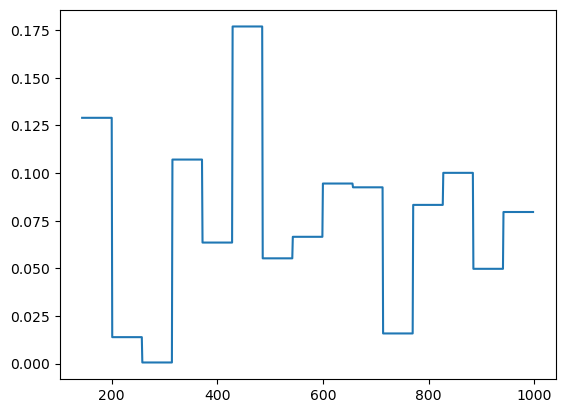

In [72]:
mag = np.abs(lambdas[3,:])
plt.plot(t,np.log(1/mag))

<AxesSubplot: >

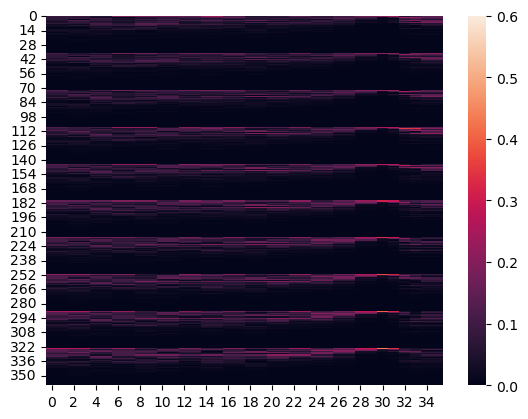

In [208]:
sns.heatmap(np.abs(exps[0].DMD.modes),vmin=0,vmax=0.6)

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350])

(36, 36)

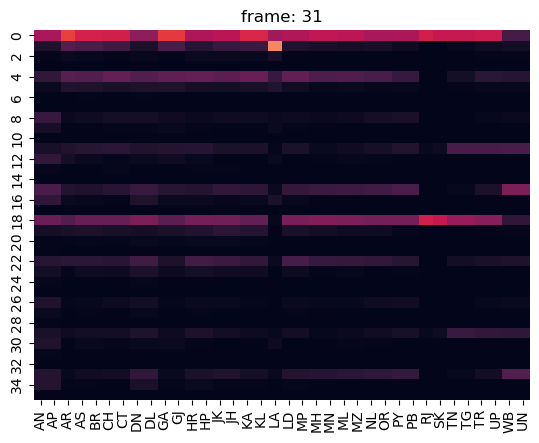

In [229]:
from matplotlib import animation
fig = plt.figure()
def init():
    ax1 = sns.heatmap( np.abs( exps[0].DMD.modes[np.arange(0,360,10).astype(int),:])   ,vmin=0,vmax=0.6, cbar=False)


  

def animate(i):

    ax1=  sns.heatmap(np.abs( exps[i].DMD.modes[np.arange(0,360,10).astype(int),:]) , vmax=.6, cbar=False, xticklabels=state_list)
    ax1.set_title(f"frame: {i}")





anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(exps), repeat = False)

savefile = r"test3.gif"
pillowwriter = animation.PillowWriter(fps=2)
anim.save(savefile, writer=pillowwriter)

plt.show()